# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<br><br><br><br>

# 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 50)

Выведем общую информацию о размере датасета, столбцах и количестве пропусков, а также первые 5 строк датасета:

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


ВЫВОДЫ:

Загруженный датафрейм представляет собой таблицу из 23699 записей и 22 столбцов. Видим, что заполнена далеко не вся таблица, пропущенные значения выявлены в 14 столбцах. Также наблюдаются несколько столбцов с несоответствующими типами данных.

<br><br><br><br>

# 2. Проведём предобработку данных

Первым делом проверим датасет на наличие дубликатов - выясним, есть ли в нём записи с одинаковыми квартирами и, если такие найдутся, удалим их.

## 2.1. Проверим датасет на наличие дубликатов

Проверять будем по нескольким параметрам-столбцам, которые максимально заполнены значениями в датасете и не меняются со временем (как, например, может поменяться цена, количество фотографий, и сама дата размещения). Это такие параметры, как общая площадь, количество комнат, этаж, этажность дома, населенный пункт, картографические данные:

In [4]:
# список столбцов, по которым будут определяться дубликаты
columns = ['total_area', 'rooms', 'floors_total', 'floor', 'studio', 'open_plan', 
           'locality_name', 'airports_nearest', 'cityCenters_nearest', 
           'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']

# сортируем датафрейм по нескольким столбцам, чтобы все дубликаты были рядом друг с другом и была возможность их изучить
df = df.sort_values(by=['total_area', 'rooms', 'floor', 'floors_total', 'locality_name', 'first_day_exposition'])

filter1 = df.duplicated(subset=columns, keep=False)   # пометить все дубликаты как True
filter2 = df.duplicated(subset=columns, keep='last')  # пометить дубликаты как True, за исключением последнего вхождения

print(f'Обнаружено дублирующих строк на удаление: {len(df[filter2])}')
print(f'Всего обнаружено {len(df[filter1])} строк, содержащих одинаковые квартиры. Рассмотрим первые 10:')
df[filter1].head(10)

Обнаружено дублирующих строк на удаление: 204
Всего обнаружено 385 строк, содержащих одинаковые квартиры. Рассмотрим первые 10:


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
17578,6,1680000.0,21.4,2015-10-29T00:00:00,1,NaN,18.0,16.20,6,NaN,False,False,NaN,0.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,252.0
12741,9,1800000.0,21.4,2018-07-21T00:00:00,1,NaN,18.0,13.00,6,NaN,False,False,NaN,NaN,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,40.0
5221,4,1050000.0,25.0,2017-11-20T00:00:00,1,NaN,2.0,20.00,1,NaN,False,False,5.0,NaN,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,98.0
3557,11,1950000.0,25.0,2017-12-18T00:00:00,1,NaN,2.0,NaN,1,NaN,False,False,NaN,NaN,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,36.0
18522,11,2800000.0,28.8,2018-03-17T00:00:00,1,2.6,9.0,14.00,4,NaN,False,False,6.0,NaN,Санкт-Петербург,13282.0,14747.0,0.0,NaN,0.0,NaN,4.0
14808,8,3399000.0,28.8,2018-08-07T00:00:00,1,2.5,9.0,15.10,4,NaN,False,False,6.6,NaN,Санкт-Петербург,13282.0,14747.0,0.0,NaN,0.0,NaN,72.0
4193,3,1850000.0,30.0,2016-09-14T00:00:00,1,NaN,5.0,17.36,1,NaN,False,False,5.0,0.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,355.0
17377,10,2350000.0,30.0,2018-02-22T00:00:00,1,NaN,5.0,17.00,1,NaN,False,False,5.2,NaN,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,253.0
16578,6,1350000.0,30.0,2018-05-31T00:00:00,1,2.7,5.0,17.00,1,False,False,False,6.0,NaN,Кириши,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14118,4,1060000.0,30.0,2018-06-20T00:00:00,1,2.5,5.0,18.00,1,NaN,False,False,6.0,NaN,Кириши,NaN,NaN,NaN,NaN,NaN,NaN,224.0


Убеждаемся, что в списке, похоже, действительно одни и те же квартиры, дублирующиеся по 2, а иногда по 3 раза. Удалим дубликаты за исключением последнего вхождения (согласно сортировке оставим самую позднюю, актуальную запись):

In [5]:
dfsize = df.shape[0]
df = df.drop_duplicates(subset=columns, keep='last')
df = df.sort_index()  # возвращаем сортировку по индексу

print('Удалено дубликатов:         ', dfsize - df.shape[0])
print('Осталось записeй в датасете:', df.shape[0])

Удалено дубликатов:          204
Осталось записeй в датасете: 23495


Далее изучим все столбцы датасета на предмет пропущенных значений (можно ли их заполнить, и какими именно значениями), преобразуем тип данных при необходимости, удалим неявные дубликаты и экстремальные значения в данных.

<br><br>

## 2.2. Столбец `total_images`

Пропусков нет, тип данных целочисленный. Проверим на выбросы. Выведем основные описательные статистики, построим гистограмму и диаграмму размаха:

In [6]:
df['total_images'].describe()

count    23495.000000
mean         9.867078
std          5.684775
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64

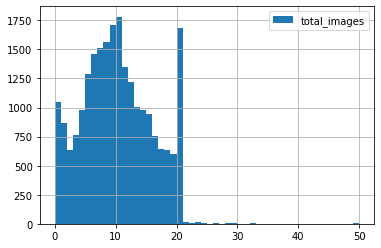

In [7]:
df['total_images'].hist(bins=df['total_images'].max(), legend=True)
plt.show()

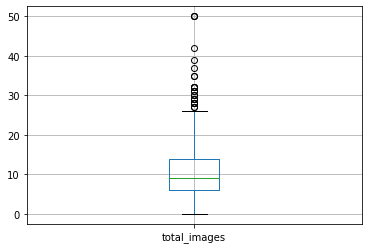

In [8]:
df.boxplot(column='total_images')
plt.show()

In [9]:
print('Пары значений:\nКоличество фотографий - Количество квартир')
df['total_images'].value_counts().sort_index()

Пары значений:
Количество фотографий - Количество квартир


0     1046
1      864
2      633
3      764
4      975
5     1292
6     1462
7     1512
8     1567
9     1708
10    1781
11    1349
12    1216
13    1007
14     976
15     945
16     753
17     647
18     639
19     600
20    1685
21      12
22       8
23      15
24       8
25       1
26       5
27       2
28       4
29       3
30       2
31       2
32       4
35       2
37       1
39       1
42       1
50       3
Name: total_images, dtype: int64

In [10]:
print('Количество выбросов:', len(df.query('total_images > 26')))

Количество выбросов: 25


Итак, количество фотографий в объявлениях характерно в значениях от 0 до 26. Среднее значение порядка 10. В датасете достаточно много объявлений с 20 фотографиями и совсем небольшое количество с 21-50 фотографиями. Количество выбросов всего 25 (0.1%). Смысла их удалять нет (пока не очевидно, где выбросы в количестве фотографий могли бы повлиять на результаты исследования)

<br><br>

## 2.3. Столбец `last_price`

Пропусков нет, тип данных вещественный. На первый взгляд стоимость записана в целых рублях. Да и в принципе, учитывать копейки на фоне стоимости квартиры бессмысленно, поэтому в любом случае округлим стоимость до рублей - преобразуем тип данных в целочисленный и проверим на выбросы:

In [11]:
df['last_price'] = df['last_price'].astype('int')

In [12]:
last_price_describe = df['last_price'].describe()
last_price_describe

count    2.349500e+04
mean     6.556125e+06
std      1.091126e+07
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Минимальное значение стоимости квартиры 12190 рублей. Явный сбой. Проверим, сколько в датасете квартир стоимостью менее, скажем, 500 тысяч рублей и рассмотрим внимательней такие записи:

In [13]:
print('Количество квартир стоимостью менее 500 тыс. руб.:', len(df.query('last_price < 500000')))
df.query('last_price < 500000')

Количество квартир стоимостью менее 500 тыс. руб.: 14


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5698,7,450000,42.0,2017-07-31T00:00:00,2,NaN,1.0,23.0,1,NaN,False,False,5.8,NaN,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
6859,6,490000,40.0,2017-12-11T00:00:00,1,NaN,5.0,NaN,3,NaN,False,False,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,43.0
8793,7,12190,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,False,False,40.5,NaN,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
9581,7,450000,43.4,2018-08-31T00:00:00,2,NaN,5.0,30.3,3,NaN,False,False,5.5,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0
10782,3,490000,29.1,2016-05-05T00:00:00,1,2.50,5.0,17.0,5,NaN,False,False,5.5,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,719.0
14911,5,430000,54.0,2018-06-26T00:00:00,2,NaN,3.0,NaN,3,NaN,False,False,NaN,NaN,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
16032,8,480000,32.0,2019-01-06T00:00:00,1,NaN,2.0,16.0,1,NaN,False,False,NaN,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,83.0
16219,14,450000,38.5,2018-07-11T00:00:00,2,2.65,2.0,NaN,1,NaN,False,False,NaN,NaN,деревня Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16274,18,440000,40.0,2018-07-10T00:00:00,1,NaN,5.0,NaN,1,NaN,False,False,NaN,NaN,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
17456,7,430000,30.4,2019-04-22T00:00:00,1,NaN,2.0,16.0,1,NaN,False,False,6.0,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что в датасете 14 квартир стоимостью до 500 тыс. руб. Из них 13 квартир стоимостью выше 400 тыс. руб. (Все они расположены в пригородах Санкт-Петербурга, в деревнях и посёлках и имеют небольшую площадь. Поэтому такая цена для них вполне оправдана.)

Квартира с экстремально низкой ценой 12190 руб. - всего одна. Судя по большой площади квартиры и расположению (г. Санкт-Петербург), цена в данном случае предполагалась не в рублях, а в тысячах рублей и на самом деле составляет 12.19 млн. руб. Исправим:

In [14]:
df.loc[8793, 'last_price'] = 12190000

Теперь обратим внимание на максимальные цены. В Санкт-Петербурге не редкость квартиры стоимостью в десятки миллионов рублей (скажем, до 30 млн.) Но стоимость квартиры в сотни миллионов (максимум в датасете - 763 млн.) - это уже явно экстремальные значения. Построим диаграмму размаха:

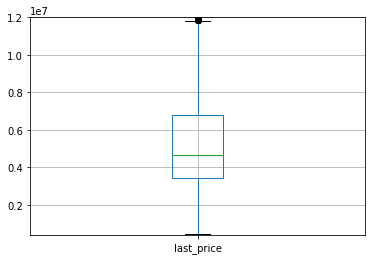

In [15]:
df.boxplot(column='last_price')
plt.ylim(400000, 12000000)
plt.show()

Диаграмма размаха показывает, что цена квартиры характерна в значениях от 400 тыс. до 12 млн. Всё что выше, уже относится к не характерным значениям, выбросам. Однако проверим, насколько редкие такие выбросы и можем ли мы их безболезненно удалить:

In [16]:
def show_flat_outliers(price):
    print(f"Количество квартир с ценой > {price / 1000000:.2f} млн. руб.:  {len(df.query('last_price > @price'))}")
    print(f"Доля таких квартир в датасете:  {len(df.query('last_price > @price')) / len(df):.2%}")

show_flat_outliers(12000000)

Количество квартир с ценой > 12.00 млн. руб.:  1926
Доля таких квартир в датасете:  8.20%


Более 8% это существенный объём данных. Не хочется их терять. Посмотрим на гистограмму распределения цены (до 50 млн.):

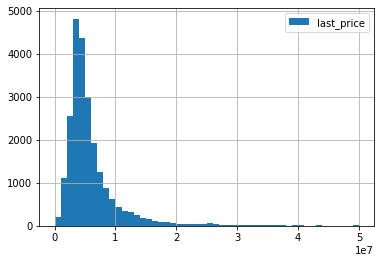

In [17]:
df['last_price'].hist(bins=50, range=(0, 50000000), legend=True)
plt.show()

Видим, что распределение "обрывается" примерно на 20 млн. Рассчитаем, сколько значений и какой их процент лежит за этой границей:

In [18]:
show_flat_outliers(20000000)

Количество квартир с ценой > 20.00 млн. руб.:  700
Доля таких квартир в датасете:  2.98%


Менее 3% потерянных данных - это уже приемлемый уровень. Удалим из датасета все квартиры с ценами более 20 млн.:

In [19]:
df = df.query('last_price <= 20000000')
print('Осталось записeй в датасете:', df.shape[0])

Осталось записeй в датасете: 22795


Сравним описательные статистики столбца до и после удаления выбросов:

In [20]:
print('До удаления выбросов:')
print(last_price_describe)
print()
print('После удаления выбросов:')
print(df['last_price'].describe())

До удаления выбросов:
count    2.349500e+04
mean     6.556125e+06
std      1.091126e+07
min      1.219000e+04
25%      3.450000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

После удаления выбросов:
count    2.279500e+04
mean     5.438636e+06
std      3.216517e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.580000e+06
75%      6.500000e+06
max      2.000000e+07
Name: last_price, dtype: float64


Видим, что медианное значение изменилось всего на 0.07 млн, тогда как среднее - более чем на 1.1 млн., что лишний раз подтверждает чувствительность среднего к выбросам.

<br><br>

## 2.4. Столбец `total_area`

Пропусков нет, тип данных вещественный, всё в порядке. Проверим на выбросы:

In [21]:
df['total_area'].describe()

count    22795.000000
mean        56.783059
std         24.829907
min         12.000000
25%         40.000000
50%         51.000000
75%         67.200000
max        460.800000
Name: total_area, dtype: float64

Видим минимальное значение всего 12 м.кв., а максимальное - 460.8 м.кв. Проверим, это ошибки и сбои, или нет. Выведем сначала квартиры с площадью менее, скажем, 20 м.кв., а затем более 250 м.кв.:

In [22]:
print('Количество квартир с площадью менее 20 м.кв.:', len(df.query('total_area < 20')))
df.query('total_area < 20')

Количество квартир с площадью менее 20 м.кв.: 27


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
716,5,1500000,17.00,2017-06-07T00:00:00,0,2.70,9.0,12.00,1,NaN,True,False,NaN,0.0,посёлок Шушары,18654.0,29846.0,0.0,NaN,0.0,NaN,40.0
4542,12,3300000,18.00,2018-11-07T00:00:00,1,3.50,5.0,9.00,2,NaN,False,False,NaN,NaN,Санкт-Петербург,25157.0,4948.0,2.0,349.0,1.0,963.0,9.0
5855,3,945750,19.50,2017-09-18T00:00:00,0,2.76,3.0,12.70,2,False,True,False,NaN,0.0,поселок городского типа Дубровка,NaN,NaN,NaN,NaN,NaN,NaN,3.0
6084,6,770000,18.00,2017-10-16T00:00:00,1,NaN,5.0,13.00,4,NaN,False,False,3.0,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,90.0
8454,7,2250000,19.00,2019-03-12T00:00:00,0,3.00,6.0,NaN,2,NaN,True,False,NaN,NaN,Санкт-Петербург,12430.0,7316.0,1.0,238.0,3.0,374.0,44.0
8729,9,2200000,18.40,2018-08-20T00:00:00,1,2.52,3.0,14.00,3,NaN,False,False,2.4,NaN,Пушкин,20710.0,30687.0,0.0,NaN,1.0,155.0,59.0
8755,1,1350000,18.80,2017-11-22T00:00:00,0,2.75,19.0,15.80,1,NaN,True,False,NaN,NaN,Санкт-Петербург,37636.0,14479.0,0.0,NaN,1.0,1127.0,128.0
8886,10,2450000,15.50,2018-08-22T00:00:00,0,NaN,5.0,10.00,2,NaN,True,False,NaN,NaN,Санкт-Петербург,24326.0,4589.0,0.0,NaN,1.0,446.0,27.0
9157,0,3400000,17.60,2018-03-18T00:00:00,1,NaN,5.0,15.00,2,NaN,False,False,NaN,NaN,Санкт-Петербург,21555.0,1967.0,2.0,336.0,1.0,309.0,117.0
9412,5,2100000,16.00,2017-12-10T00:00:00,0,NaN,6.0,13.00,1,NaN,False,True,NaN,NaN,Санкт-Петербург,20735.0,2111.0,2.0,228.0,3.0,72.0,3.0


In [23]:
print('Количество квартир с площадью более 250 м.кв.:', len(df.query('total_area > 250')))
df.query('total_area > 250')

Количество квартир с площадью более 250 м.кв.: 7


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2489,9,12500000,255.0,2017-04-21T00:00:00,3,NaN,2.0,153.9,2,NaN,False,False,100.70,0.0,Санкт-Петербург,29544.0,6916.0,0.0,NaN,3.0,198.0,102.0
9397,10,16073000,263.8,2019-01-30T00:00:00,3,NaN,19.0,NaN,4,NaN,False,False,23.42,NaN,Санкт-Петербург,18805.0,4400.0,0.0,NaN,0.0,NaN,35.0
11087,3,14000000,320.0,2017-09-27T00:00:00,6,NaN,3.0,190.0,3,NaN,False,False,28.00,0.0,Красное Село,26020.0,29445.0,1.0,569.0,0.0,NaN,8.0
12067,5,14500000,259.6,2015-09-28T00:00:00,5,2.81,17.0,148.6,16,NaN,False,False,15.40,NaN,Санкт-Петербург,39408.0,11111.0,0.0,NaN,0.0,NaN,1232.0
13397,14,19500000,309.7,2016-02-03T00:00:00,9,NaN,5.0,199.0,5,NaN,False,False,14.30,0.0,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,468.0
20273,12,20000000,460.8,2019-03-20T00:00:00,6,3.10,3.0,279.6,1,NaN,False,False,55.50,NaN,Санкт-Петербург,43756.0,15459.0,1.0,852.0,3.0,122.0,21.0
22238,12,19500000,287.5,2017-12-27T00:00:00,7,NaN,4.0,183.7,3,NaN,False,False,26.00,NaN,Санкт-Петербург,21881.0,4726.0,1.0,578.0,1.0,853.0,90.0


Видим, что это не ошибки. Действительно, есть и микро-квартиры (однокомнатные или студии) площадью менее 20 м.кв. и огромные квартиры площадью более 250 м.кв.

<br><br>

## 2.5. Столбец `first_day_exposition`

Пропусков нет, тип данных строковый. Также видим, что заполнена только дата, время везде `00:00:00`. Преобразуем в формат даты-времени:

In [24]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%d')

In [25]:
df['first_day_exposition'].describe(datetime_is_numeric=True)

count                            22795
mean     2017-11-13 21:16:45.852160512
min                2014-11-27 00:00:00
25%                2017-05-18 00:00:00
50%                2017-12-15 00:00:00
75%                2018-08-28 00:00:00
max                2019-05-03 00:00:00
Name: first_day_exposition, dtype: object

Видим, что аномальных значений дат нет. Самая ранняя запись датируется 27.11.2014, а самая поздняя - 03.05.2019

<br><br>

## 2.6. Столбец `rooms`

Пропусков нет, тип данных целочисленный, всё в порядке. Проверим возможные значения количества комнат:

In [26]:
print('Пары значений:\nКоличество комнат - Количество квартир')
df['rooms'].value_counts().sort_index()

Пары значений:
Количество комнат - Количество квартир


0      196
1     7960
2     7791
3     5531
4     1002
5      224
6       61
7       21
8        5
9        2
10       1
11       1
Name: rooms, dtype: int64

Требуют проверки 9 квартир с количеством комнат более 7:

In [27]:
print('Квартир с количеством комнат более 7:', len(df.query('rooms > 7')))
df.query('rooms > 7')

Квартир с количеством комнат более 7: 9


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
648,3,17500000,183.7,2018-07-01,11,3.40,7.0,138.8,7,NaN,False,False,13.3,NaN,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
813,7,16500000,229.0,2016-02-25,8,NaN,6.0,160.0,5,NaN,False,False,25.0,NaN,Санкт-Петербург,23968.0,4536.0,1.0,243.0,0.0,NaN,806.0
8758,5,16100000,150.0,2018-07-10,8,2.92,5.0,107.0,1,NaN,False,False,7.2,NaN,Санкт-Петербург,26080.0,4782.0,2.0,473.0,0.0,NaN,NaN
8860,12,17000000,235.0,2018-07-14,9,3.00,6.0,NaN,3,NaN,False,False,NaN,NaN,Санкт-Петербург,24466.0,5034.0,1.0,346.0,0.0,NaN,90.0
12447,8,19900000,210.3,2016-04-18,8,3.30,5.0,144.6,2,NaN,False,False,23.6,0.0,Санкт-Петербург,24770.0,5864.0,2.0,283.0,0.0,NaN,102.0
13397,14,19500000,309.7,2016-02-03,9,NaN,5.0,199.0,5,NaN,False,False,14.3,0.0,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,468.0
18119,4,15500000,216.1,2016-07-04,10,3.15,5.0,161.4,2,NaN,False,False,19.8,0.0,Санкт-Петербург,24353.0,4921.0,1.0,368.0,0.0,NaN,11.0
18945,4,15800000,236.4,2015-02-19,8,NaN,6.0,176.6,6,NaN,False,False,22.6,0.0,Санкт-Петербург,20221.0,1802.0,3.0,571.0,3.0,441.0,921.0
20788,7,18000000,245.0,2017-04-06,8,3.54,5.0,155.0,2,NaN,False,False,NaN,NaN,Санкт-Петербург,22215.0,2424.0,1.0,867.0,1.0,340.0,357.0


Видим, что квартиры с количеством комнат больше 7 - это действительно большие квартиры с площадью от 150 м.кв. и выше, так что всё логично.

Также пока не понятно, что такое 0 комнат (196 квартир):

In [28]:
print('Квартир с количеством комнат 0:', len(df.query('rooms == 0')))
df.query('rooms == 0').head()

Квартир с количеством комнат 0: 196


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000,27.00,2017-03-30,0,NaN,24.0,15.50,2,NaN,True,False,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
349,4,2320000,25.00,2017-09-27,0,NaN,14.0,17.00,1,NaN,False,True,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
440,8,2480000,27.11,2018-03-12,0,NaN,17.0,24.75,4,NaN,True,False,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
508,0,3375000,34.40,2017-03-28,0,NaN,26.0,24.30,19,NaN,False,True,NaN,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
608,2,1850000,25.00,2019-02-20,0,NaN,10.0,NaN,7,NaN,True,False,NaN,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0


Квартирами с количеством комнат 0 обозначаются либо квартиры-студии, либо квартиры с открытой планировкой. Тут тоже всё в порядке, оставим как есть.

<br><br>

## 2.7. Столбец `ceiling_height`

Есть много пропущенных значений. Тип данных вещественный.

Рассмотрим квартиры с очень маленькими (менее 2 метров) и очень большими (более 10 метров) значениями высоты потолков:

In [29]:
print('Самые низкие потолки (ниже 2 метров):')
print(df.loc[df['ceiling_height'] < 2, 'ceiling_height'].value_counts().sort_index())
print()
print('Самые высокие потолки (выше 10 метров):')
print(df.loc[df['ceiling_height'] > 10, 'ceiling_height'].value_counts().sort_index())

Самые низкие потолки (ниже 2 метров):
1.00    1
1.20    1
1.75    1
Name: ceiling_height, dtype: int64

Самые высокие потолки (выше 10 метров):
10.3     1
14.0     1
20.0     1
22.6     1
24.0     1
25.0     6
26.0     1
27.0     8
27.5     1
32.0     2
100.0    1
Name: ceiling_height, dtype: int64


Начнём с аномально высоких потолков. Скорее всего это ошибка ввода данных - неправильно поставленный десятичный разделитель. Вместо значения 25 м. должно быть 2.5 м., вместо 27.5 - 2.75 и т.д. Разделим такие аномальные значения на 10 и выведем заново список самых низких и самых высоких потолков:

In [30]:
df.loc[df['ceiling_height'] > 10, 'ceiling_height'] = df.loc[df['ceiling_height'] > 10, 'ceiling_height'] / 10

In [31]:
print('Самые низкие потолки (ниже 2 метров):')
print(df.loc[df['ceiling_height'] < 2, 'ceiling_height'].value_counts().sort_index())
print()
print('Самые высокие потолки (выше 10 метров):')
print(df.loc[df['ceiling_height'] > 10, 'ceiling_height'].value_counts().sort_index())

Самые низкие потолки (ниже 2 метров):
1.00    1
1.03    1
1.20    1
1.40    1
1.75    1
Name: ceiling_height, dtype: int64

Самые высокие потолки (выше 10 метров):
Series([], Name: ceiling_height, dtype: int64)


Итак, мы избавились от аномально больших значений для высоты потолков. Осталось 5 квартир с аномально низкими потолками. Рассмотрим эти квартиры:

In [32]:
print('Квартир с аномально низкими потолками (меньше 2 м):', len(df.query('ceiling_height < 2')))
df.query('ceiling_height < 2')

Квартир с аномально низкими потолками (меньше 2 м): 5


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5712,5,1500000,42.8,2017-08-14,2,1.20,2.0,27.5,1,NaN,False,False,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
15061,19,5600000,56.4,2018-05-11,2,1.40,14.0,32.4,5,NaN,False,False,9.10,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
16934,5,4100000,40.0,2017-10-17,1,1.75,37.0,17.4,5,NaN,False,False,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
22309,20,5300000,45.0,2017-09-30,1,1.03,16.0,15.5,15,NaN,False,False,NaN,NaN,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0
22590,16,6000000,55.0,2018-10-31,2,1.00,12.0,32.4,7,NaN,False,False,10.00,NaN,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0


Квартиры выглядят обычными, за исключением необычно низких потолков. Природа такой аномалии не ясна (видимо, ошибка при вводе данных), поэтому очистим эти значения - поставим пропуски, None (NaN) и выведем итоговые 5 минимальных и 5 максимальных значений, а также медианное значение:

In [33]:
df.loc[df['ceiling_height'] < 2, 'ceiling_height'] = None

In [34]:
print('Минимальные значения высоты потолков:')
print(df['ceiling_height'].value_counts().sort_index().head())
print()
print('Максимальные значения высоты потолков:')
print(df['ceiling_height'].value_counts().sort_index().tail())
print()
ceiling_height_median = df['ceiling_height'].median()
print('Медианное значение высоты потолков:', ceiling_height_median)

Минимальные значения высоты потолков:
2.00    12
2.20     1
2.25     1
2.26     1
2.30     4
Name: ceiling_height, dtype: int64

Максимальные значения высоты потолков:
5.3     1
5.8     1
8.0     3
8.3     1
10.0    1
Name: ceiling_height, dtype: int64

Медианное значение высоты потолков: 2.65


Теперь заполним пропущенные значения медианным и проверим, что пропусков в столбце больше нет:

In [35]:
df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = ceiling_height_median

In [36]:
print('Пропущенных значений в столбце `ceiling_height`:', df['ceiling_height'].isna().sum())

Пропущенных значений в столбце `ceiling_height`: 0


<br><br>

## 2.8. Столбец `floors_total`

Есть немного пропущенных значений (84 шт). Тип данных вещественный - заменим на целочисленный, т.к. количество этажей не может быть вещественным:

In [37]:
df['floors_total'] = df['floors_total'].astype('Int64')

Рассмотрим подробнее записи с пропусками в этом столбце:

In [38]:
df[df['floors_total'].isna()].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000,65.20,2018-10-02,2,2.65,<NA>,30.80,4,NaN,False,False,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033,28.10,2016-11-23,1,2.65,<NA>,20.75,1,NaN,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348,70.80,2015-08-01,2,2.65,<NA>,38.40,12,NaN,False,False,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191,93.60,2017-04-06,3,2.65,<NA>,47.10,8,NaN,False,False,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000,39.00,2017-04-22,1,2.65,<NA>,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
1930,1,9750000,66.77,2016-05-13,2,2.65,<NA>,NaN,4,NaN,False,False,NaN,0.0,Санкт-Петербург,39886.0,10660.0,1.0,2276.0,3.0,244.0,90.0
2392,7,5395770,53.00,2017-06-29,2,2.65,<NA>,29.00,22,NaN,False,False,9.00,0.0,Санкт-Петербург,43074.0,10820.0,0.0,NaN,0.0,NaN,48.0
2846,4,2325000,27.80,2016-09-21,1,2.65,<NA>,19.40,15,NaN,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,307.0
2952,10,6500000,54.30,2019-04-23,1,2.65,<NA>,22.20,6,NaN,False,False,12.30,NaN,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
3031,9,6400000,56.70,2018-03-27,2,2.65,<NA>,32.00,12,NaN,False,False,12.00,NaN,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,231.0


Никаких закономерностей, почему в данных квартирах не указана общая этажность дома, не выявлено. Видимо, человеческий фактор - просто забыли вписать. Пропуски заполнить не представляется возможным.

Проверим значения столбца на выбросы:

In [39]:
df['floors_total'].describe()

count    22711.000000
mean        10.765532
std          6.636470
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [40]:
print('Пары значений:\nЭтажность дома - Количество квартир')
df['floors_total'].value_counts().sort_index()

Пары значений:
Этажность дома - Количество квартир


1       25
2      372
3      641
4     1135
5     5551
6      806
7      517
8      305
9     3701
10    1135
11     188
12    1325
13     218
14     549
15     347
16    1348
17     817
18     490
19     331
20     261
21     158
22     281
23     343
24     466
25    1062
26     123
27     162
28      21
29       1
33       1
34       1
35      24
36       3
37       1
52       1
60       1
Name: floors_total, dtype: Int64

Всё в порядке, экстремальных значений и выбросов не обнаружено

<br><br>

## 2.9. Столбцы `living_area` и `kitchen_area`

Оба столбца имеют вещественный тип данных, здесь всё ок. В обоих столбцах есть пропуски, которые необходимо заполнить (Очевидно, человеческий фактор - не заполнили при публикации объявления).

Но вначале выполним простую проверку на аномальность данных: проверим, что сумма жилой площади и площади кухни не превышает общую площадь для каждой квартиры:

In [41]:
print('Количество квартир, где общая площадь меньше суммы жилой площади и площади кухни:', \
      len(df.query('total_area < living_area + kitchen_area')))
df.query('total_area < living_area + kitchen_area')

Количество квартир, где общая площадь меньше суммы жилой площади и площади кухни: 64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000,30.20,2018-02-14,1,2.65,9,26.10,5,NaN,False,False,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
545,9,4700000,23.80,2018-12-28,1,2.65,18,20.00,9,NaN,False,False,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000,31.59,2018-03-08,1,2.70,19,30.55,2,NaN,False,False,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
601,12,5600000,53.70,2017-04-18,2,2.50,12,48.30,5,NaN,False,False,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
696,1,3364930,34.69,2014-11-27,1,2.64,25,23.43,25,NaN,False,False,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
1060,10,5200000,50.00,2015-11-06,2,2.65,35,39.00,15,False,False,False,20.50,2.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,281.0
1155,11,7000000,38.00,2019-04-09,1,3.20,5,33.00,1,NaN,False,False,12.00,NaN,Санкт-Петербург,31501.0,3670.0,1.0,183.0,3.0,689.0,NaN
1354,14,7300000,54.50,2018-08-20,2,2.65,16,38.00,12,NaN,False,False,19.00,2.0,Санкт-Петербург,51030.0,14721.0,0.0,NaN,0.0,NaN,NaN
1407,9,3250000,24.60,2018-06-29,1,2.65,25,18.00,16,NaN,False,False,18.20,NaN,Санкт-Петербург,35250.0,16414.0,0.0,NaN,1.0,400.0,96.0
1854,3,6540000,60.20,2018-10-14,2,2.65,24,55.00,24,NaN,False,False,14.84,NaN,Санкт-Петербург,33606.0,14769.0,0.0,NaN,0.0,NaN,60.0


Выявлено 64 квартиры с явными ошибками в значениях площадей (общей, жилой, кухни). Определить однозначно источник ошибки не представляется возможным. Данная аномалия не связана с тем, является ли квартира студией, или нет. В каких-то квартирах площадь кухни кажется явно завышенной, в каких-то наоборот, завышена жилая площадь. Видимо, это ошибки при заполнении и публикации объявления. Обнулим эти аномальные значения (заменим на пропуски):

In [42]:
df.loc[df['total_area'] < df['living_area'] + df['kitchen_area'], ['living_area', 'kitchen_area']] = None

Теперь проверим жилую площадь на экстремально низкие значения, скажем, меньше 7 м.кв. (При этом понимаем, что кухня может быть сколь угодно маленькой, например, в студиях, или квартирах с открытой планировкой):

In [43]:
print('Квартир с аномально маленькой жилой площадью (меньше 7 м.кв.):', len(df.query('living_area < 7')))
df.query('living_area < 7')

Квартир с аномально маленькой жилой площадью (меньше 7 м.кв.): 7


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000,41.0,2017-07-02,1,2.65,17,3.0,17,NaN,False,False,11.0,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
13915,20,6350000,52.0,2018-02-06,2,3.00,6,2.0,2,NaN,False,False,9.0,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
16431,13,3799000,31.0,2018-04-12,1,2.60,5,6.0,1,NaN,False,False,17.0,NaN,Санкт-Петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0
17582,11,2680000,22.0,2018-08-11,0,2.65,25,5.0,8,NaN,True,False,NaN,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
19251,19,4050000,33.0,2018-10-15,1,2.50,22,6.5,21,NaN,False,False,18.0,NaN,Санкт-Петербург,9258.0,10592.0,1.0,458.0,0.0,NaN,44.0
21758,0,2330000,23.0,2018-01-01,0,2.65,24,2.0,22,NaN,True,False,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
21943,15,6100000,77.6,2019-02-28,4,2.50,9,5.4,1,NaN,False,False,9.8,NaN,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0


Видим, что жилая площадь в этих квартирах неоправданно маленькая, не смотря на позволяющую общую площадь и больших размеров кухни. Обнулим значения и жилой площади, и кухни для этих квартир:

In [44]:
df.loc[df['living_area'] < 7, ['living_area', 'kitchen_area']] = None

Далее - восстановим все пропуски в столбцах `living_area` и `kitchen_area` следующим образом:

Для каждой квартиры у нас есть заполненная общая площадь (столбец `total_area` без пропусков). Общая площадь складывается из жилой площади, площади кухни и остальной площади (коридоры, санузлы и т.п.). Рассчитаем, как в среднем соотносятся эти площади для "средней квартиры": Выберем из датасета те записи, где заполнены также жилая площадь и площадь кухни и вычислим коэффициенты для жилой площади, площади кухни, и площади остальных помещений (`living_k`, `kitchen_k` и `other_k`):

In [45]:
filter = (~(df['living_area'].isna())) & (~(df['kitchen_area'].isna()))
living_k = (df.loc[filter, 'living_area'] / df.loc[filter, 'total_area']).mean()
kitchen_k = (df.loc[filter, 'kitchen_area'] / df.loc[filter, 'total_area']).mean()
other_k = 1 - living_k - kitchen_k

In [46]:
living_k, kitchen_k, other_k

(0.5617921449394352, 0.18743578260716587, 0.25077207245339894)

Выберем из датасета по три тестовых записи для каждой из трёх категорий: 1. где жилая площадь и площадь кухни пропущены, 2. где пропущена только жилая площадь, 3. где пропущена только площадь кухни. И проверим, как будут заполняться пропуски:

In [47]:
def area_filling_test():
    display(df.loc[[30, 37, 44, 7, 116, 165, 178, 188, 199], ['total_area', 'living_area', 'kitchen_area']])
area_filling_test()

,total_area,living_area,kitchen_area
30,32.8,NaN,NaN
37,45.8,NaN,NaN
44,40.0,NaN,NaN
7,71.6,NaN,18.9
116,97.2,NaN,18.3
165,60.2,NaN,10.2
178,153.0,89.4,NaN
188,38.5,18.5,NaN
199,37.4,17.0,NaN


Заполлним пропуски для жилой площади в тех квартирах, где также не заполнена и площадь кухни:

In [48]:
filter = (df['living_area'].isna()) & (df['kitchen_area'].isna())
df.loc[filter, 'living_area'] = df.loc[filter, 'total_area'] * living_k
df['living_area'] = df['living_area'].round(2)

In [49]:
area_filling_test()

,total_area,living_area,kitchen_area
30,32.8,18.43,NaN
37,45.8,25.73,NaN
44,40.0,22.47,NaN
7,71.6,NaN,18.9
116,97.2,NaN,18.3
165,60.2,NaN,10.2
178,153.0,89.40,NaN
188,38.5,18.50,NaN
199,37.4,17.00,NaN


Теперь заполним пропуски для жилой площади в тех квартирах, где площадь кухни уже указана. В этом случае остаётся нераспределенная площадь (total_area - kitchen_area), которую нужно разделить между жилой площадью и площадью остальных помещений:

In [50]:
filter = (df['living_area'].isna()) & (~(df['kitchen_area'].isna()))
df.loc[filter, 'living_area'] = \
    (df.loc[filter, 'total_area'] - df.loc[filter, 'kitchen_area']) * living_k / (living_k + other_k)
df['living_area'] = df['living_area'].round(2)

In [51]:
area_filling_test()

,total_area,living_area,kitchen_area
30,32.8,18.43,NaN
37,45.8,25.73,NaN
44,40.0,22.47,NaN
7,71.6,36.44,18.9
116,97.2,54.55,18.3
165,60.2,34.57,10.2
178,153.0,89.40,NaN
188,38.5,18.50,NaN
199,37.4,17.00,NaN


И наконец заполним пропуски для площади кухни в тех квартирах, где жилая площадь уже указана. В этом случае остаётся нераспределенная площадь (total_area - living_area), которую нужно разделить между площадью кухни и площадью остальных помещений:

In [52]:
filter = (~(df['living_area'].isna())) & (df['kitchen_area'].isna())
df.loc[filter, 'kitchen_area'] = \
    (df.loc[filter, 'total_area'] - df.loc[filter, 'living_area']) * kitchen_k / (kitchen_k + other_k)
df['kitchen_area'] = df['kitchen_area'].round(2)

In [53]:
area_filling_test()

,total_area,living_area,kitchen_area
30,32.8,18.43,6.15
37,45.8,25.73,8.58
44,40.0,22.47,7.50
7,71.6,36.44,18.90
116,97.2,54.55,18.30
165,60.2,34.57,10.20
178,153.0,89.40,27.20
188,38.5,18.50,8.55
199,37.4,17.00,8.73


По тестовым записям видно, что пропуски в столбцах `living_area` и `kitchen_area` заполняются корректно


Проверим столбцы `living_area` и `kitchen_area` на предмет экстремальных значений:

In [54]:
print('Столбец `living_area`:')
df['living_area'].describe()

Столбец `living_area`:


count    22795.000000
mean        32.507010
std         16.657066
min          7.300000
25%         18.700000
50%         30.000000
75%         41.000000
max        279.600000
Name: living_area, dtype: float64

In [55]:
print('Столбец `kitchen_area`:')
df['kitchen_area'].describe()

Столбец `kitchen_area`:


count    22795.000000
mean        10.041973
std          4.763982
min          0.000000
25%          7.000000
50%          9.000000
75%         11.575000
max        100.700000
Name: kitchen_area, dtype: float64

Всё в порядке. Максимальные значения площадей соответствуют большим квартирам. Минимальное значение жилой площади больше 7 м.кв., а площадь кухни может быть сколь угодно маленькой в студиях и квартирах с открытой планировкой

Напоследок проверим, что после заполнения всех пропущенных значений сумма жилой площади и площади кухни по-прежнему не превышает общую площадь для каждой квартиры:

In [56]:
print('Количество квартир, где общая площадь меньше суммы жилой площади и площади кухни:', 
      len(df.query('total_area < living_area + kitchen_area')))

Количество квартир, где общая площадь меньше суммы жилой площади и площади кухни: 0


<br><br>

## 2.10. Столбец `floor`

Пропусков нет, тип данных целочисленный, всё в порядке. Проверим на выбросы:

In [57]:
df['floor'].describe()

count    22795.000000
mean         5.909542
std          4.909059
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

In [58]:
print('Пары значений:\nЭтаж - Количество квартир')
df['floor'].value_counts().sort_index()

Пары значений:
Этаж - Количество квартир


1     2841
2     3245
3     2944
4     2653
5     2501
6     1237
7     1160
8     1043
9     1027
10     666
11     511
12     513
13     369
14     328
15     334
16     308
17     223
18     174
19     134
20     107
21     120
22     112
23      99
24      62
25      44
26      24
27      10
28       1
29       1
30       1
31       1
32       1
33       1
Name: floor, dtype: int64

Всё в порядке, экстремальных значений и выбросов не обнаружено

Также убеждаемся, что в датасете отсутствуют такие аномальные записи, где этаж квартиры больше этажности дома:

In [59]:
print('Количество квартир, где этаж квартиры больше этажности дома:', len(df.query('floor > floors_total')))

Количество квартир, где этаж квартиры больше этажности дома: 0


<br><br>

## 2.11. Столбец `is_apartment`

Тип данных - строковый (хотя должен быть логический). В столбце очень много пропусков.

In [60]:
print('Столбец `is_apartment`:')
print(df['is_apartment'].value_counts())

Столбец `is_apartment`:
False    2617
True       41
Name: is_apartment, dtype: int64


Апартаменты – это нежилая коммерческая недвижимость. Из-за особого статуса в таком помещении нельзя оформить постоянную регистрацию. Это важный параметр объекта (и таких объектов немного в датасете), поэтому логично предположить, что если недвижимость имеет статус аппартаментов, то в столбце точно проставлено значение True (41 значение), в любых других случаях может быть либо False (2617 значений), либо значение может быть не заполнено (все остальные значения).

Заменим все пропуски на False:

In [61]:
df.loc[df['is_apartment'].isna(), 'is_apartment'] = False

Теперь преобразуем к логическому типу данных и убедимся, что всё в порядке:

In [62]:
df['is_apartment'] = df['is_apartment'].astype('bool')

In [63]:
print('Столбец `is_apartment`:')
print(df['is_apartment'].value_counts())

Столбец `is_apartment`:
False    22754
True        41
Name: is_apartment, dtype: int64


<br><br>

## 2.12. Столбцы `studio` и `open_plan`

Пропусков нет, тип данных - логический. Всё в порядке:

In [64]:
print('Столбец `studio`:')
print(df['studio'].value_counts())
print()
print('Столбец `open_plan`:')
print(df['open_plan'].value_counts())

Столбец `studio`:
False    22646
True       149
Name: studio, dtype: int64

Столбец `open_plan`:
False    22730
True        65
Name: open_plan, dtype: int64


<br><br>

## 2.13. Столбец `balcony`

Есть пропуски в столбце (около половины значений). Тип данных вещественный. Проверим какие значения встречаются в столбце, нет ли аномальных значений:

In [65]:
print('Пары значений:\nКоличество балконов - Количество квартир')
df['balcony'].value_counts().sort_index()

Пары значений:
Количество балконов - Количество квартир


0.0    3593
1.0    4036
2.0    3591
3.0      76
4.0     165
5.0     284
Name: balcony, dtype: int64

Всё в порядке, значения нормальные

Заменим все пропуски на 0 (если продавец не указал число балконов, то, скорее всего, в его квартире их нет):

In [66]:
df.loc[df['balcony'].isna(), 'balcony'] = 0

Изменим тип данных на целочисленный (количество балконов не может быть вещественным числом):

In [67]:
df['balcony'] = df['balcony'].astype('int')

Убеждаемся, что всё в порядке:

In [68]:
print('Пары значений:\nКоличество балконов - Количество квартир')
df['balcony'].value_counts().sort_index()

Пары значений:
Количество балконов - Количество квартир


0    14643
1     4036
2     3591
3       76
4      165
5      284
Name: balcony, dtype: int64

<br><br>

## 2.14. Столбец `locality_name`

Тип данных строковый, есть немного пропусков (47 шт). Заменим их на "Нет данных":

In [69]:
df.loc[df['locality_name'].isna(), 'locality_name'] = 'Нет данных'

Исследуем столбец на неявные дубликаты. Выведем первые несколько названий населенных пунктов, чаще всего встречающихся в датасете:

In [70]:
df['locality_name'].value_counts().head(20)

Санкт-Петербург            14990
посёлок Мурино               514
посёлок Шушары               439
Всеволожск                   389
Пушкин                       358
Колпино                      337
посёлок Парголово            326
деревня Кудрово              296
Гатчина                      278
Выборг                       215
Петергоф                     197
Сестрорецк                   182
Красное Село                 174
Кудрово                      173
деревня Новое Девяткино      144
Сертолово                    137
Ломоносов                    133
Кириши                       115
Волхов                       105
Тосно                        101
Name: locality_name, dtype: int64

Видим, что структура записи устроена следующим образом: сначала идет название административно-территориальной единицы, если оно есть, если это не сам город Санкт-Петербург и не города-спутники (всё в нижнем регистре, буквы строчные), а затем само название населенного пункта (с прописной буквы). Создадим отдельный датафрейм `locality` с этими двумя колонками, чтобы можно было применить группировку и выявить дубликаты:

In [71]:
# функция принимает на вход строку с населенным пунктом и возвращает кортеж из админ.-терр. единицы и названия
def locality_split(locality):
    lst = re.split(r'\s+(?=[А-Я])', locality)  # разделяем по заглавным буквам
    for i, item in enumerate(lst):
        if item[0].isupper():
            name = (' ').join(lst[i:])
            unit = ('').join(lst[:i])
            return unit, name

# функция принимает на вход строку с населенным пунктом и возвращает название населенного пункта
def get_locality_name(locality):
    return locality_split(locality)[1]

# функция принимает на вход строку с населенным пунктом и возвращает название админ.-терр. единицы
def get_locality_unit(locality):
    return locality_split(locality)[0]

# проверим работу функции на примере
locality = 'садовое товарищество Новая Ропша'
print(locality)
print('Админ.-терр. единица:', get_locality_unit(locality))
print('Населённый пункт:    ', get_locality_name(locality))

садовое товарищество Новая Ропша
Админ.-терр. единица: садовое товарищество
Населённый пункт:     Новая Ропша


In [72]:
# функция принимает на вход количество строк для вывода результата, выдает сгруппированный список населенных пунктов
def test_locality_dup(lines=1000):
    locality = pd.DataFrame()
    locality['name'] = df['locality_name'].apply(get_locality_name)
    locality['unit'] = df['locality_name'].apply(get_locality_unit)
    display(locality.groupby(['name', 'unit']).count().head(lines))

test_locality_dup()

Empty DataFrame
Columns: []
Index: [(Агалатово, деревня), (Александровская, посёлок), (Алексеевка, посёлок), (Аннино, поселок), (Аннино, посёлок), (Аро, деревня), (Барышево, поселок), (Батово, деревня), (Бегуницы, деревня), (Белогорка, деревня), (Белоостров, посёлок), (Бокситогорск, ), (Большая Вруда, деревня), (Большая Ижора, городской поселок), (Большая Ижора, поселок городского типа), (Большая Пустомержа, деревня), (Большие Колпаны, деревня), (Большое Рейзино, деревня), (Большой Сабск, деревня), (Бор, деревня), (Борисова Грива, деревня), (Бугры, поселок), (Бугры, посёлок), (Будогощь, городской посёлок), (Ваганово, деревня), (Важины, посёлок городского типа), (Вартемяги, деревня), (Вахнова Кара, деревня), (Вещево, поселок станции), (Вещево, посёлок при железнодорожной станции), (Виллози, городской посёлок), (Вознесенье, посёлок городского типа), (Возрождение, поселок), (Возрождение, посёлок), (Войсковицы, поселок), (Войскорово, посёлок), (Володарское, поселок), (Волосово, ), (Волхов, ), (Всеволожск, ), (Выборг, ), (Вырица, поселок городского типа), (Вырица, посёлок городского типа), (Выскатка, деревня), (Высокоключевой, посёлок), (Высоцк, ), (Гаврилово, поселок), (Гаврилово, посёлок), (Гарболово, деревня), (Гарболово, поселок), (Гатчина, ), (Гладкое, поселок), (Глажево, поселок), (Глебычево, поселок), (Глинка, деревня), (Гончарово, поселок), (Горбунки, деревня), (Гостилицы, деревня), (Громово, поселок), (Громово, посёлок станции), (Дзержинского, посёлок), (Дружная Горка, поселок городского типа), (Дружноселье, поселок), (Дубровка, поселок городского типа), (Елизаветино, поселок), (Ефимовский, поселок городского типа), (Жилгородок, поселок), (Жилгородок, посёлок), (Жилпосёлок, поселок), (Житково, поселок), (Заводской, поселок), (Заклинье, деревня), (Заневка, деревня), (Запорожское, поселок), (Зеленогорск, ), (Зимитицы, деревня), (Зимитицы, поселок), (Ивангород, ), (Извара, деревня), (Ильичёво, поселок), (Ильичёво, посёлок), (Иссад, деревня), (Калитино, деревня), (Калитино, поселок), (Каложицы, поселок), (Кальтино, деревня), (Каменногорск, ), (Камышовка, деревня), (Каськово, деревня), (Келози, деревня), (Кивеннапа Север, коттеджный поселок), (Кикерино, посёлок), (Кингисепп, ), (Кингисеппский, поселок), (Кипень, деревня), (Кириши, ), (Кировск, ), (Кирпичное, поселок), (Кисельня, деревня), (Кобралово, поселок), ...]

Видим следующие неявные дубликаты:
- `поселок`  -  `посёлок`
- `городской поселок`  -  `поселок городского типа`
- `посёлок при железнодорожной станции`  -  `посёлок станции`

Заменим и проверим снова:

In [73]:
def clean_locality_dup(locality):
    locality = locality.replace('поселок', 'посёлок')
    locality = locality.replace('городской посёлок', 'посёлок городского типа')
    locality = locality.replace('посёлок при железнодорожной станции', 'посёлок станции')
    return locality

df['locality_name'] = df['locality_name'].apply(clean_locality_dup)

test_locality_dup()

,
name,unit
Агалатово,деревня
Александровская,посёлок
Алексеевка,посёлок
Аннино,посёлок
Аро,деревня
Барышево,посёлок
Батово,деревня
Бегуницы,деревня
Белогорка,деревня


Замена выполнена успешно, неявные дубликаты удалены.

Рассмотрим квартиры, по которым нет данных о населенном пункте. Минимальное расстояние от центра Санкт-Петербурга до его границ составляет порядка 13-14 км. Соответственно, квартиры, у которых расстояние до центра города менее 13 км должны находиться в самом городе. Заменим отсутствующие значения в столбце `locality_name` на 'Санкт-Петербург' и рассмотрим оставшиеся квартиры, по которым нет данных о населенном пункте:

In [74]:
df.loc[(df['locality_name'] == "Нет данных") & (df['cityCenters_nearest'] < 13000), 'locality_name'] = 'Санкт-Петербург'

In [75]:
print('Квартир с отсутствующими данными о населенном пункте:', len(df.query('locality_name == "Нет данных"')))
df.query('locality_name == "Нет данных"')

Квартир с отсутствующими данными о населенном пункте: 20


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2033,6,5398000,80.0,2017-05-30,3,2.65,4,42.60,2,False,False,False,18.60,0,Нет данных,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765,42.7,2015-09-20,1,2.65,24,15.60,3,False,False,False,10.70,0,Нет данных,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593,62.4,2015-10-11,2,2.65,24,33.10,21,False,False,False,8.20,0,Нет данных,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
5707,7,3700000,30.0,2016-04-29,1,2.65,24,20.00,23,False,False,False,4.28,0,Нет данных,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0
6765,20,4895892,60.7,2015-03-12,2,2.65,24,31.90,3,False,False,False,12.20,0,Нет данных,22041.0,17369.0,0.0,NaN,1.0,374.0,468.0
8986,10,4850000,103.1,2018-07-10,3,2.65,<NA>,68.10,4,False,False,False,16.70,0,Нет данных,19659.0,31813.0,0.0,NaN,0.0,NaN,28.0
13223,1,2919911,29.4,2015-03-12,1,2.75,24,21.10,2,False,False,False,3.55,0,Нет данных,22041.0,17369.0,0.0,NaN,1.0,374.0,470.0
13690,7,3500000,71.0,2016-06-23,3,2.75,2,45.60,1,False,False,False,8.00,2,Нет данных,20234.0,23659.0,0.0,NaN,2.0,296.0,92.0
14273,2,4422000,60.0,2016-03-23,2,2.75,23,32.00,14,False,False,False,11.90,0,Нет данных,22041.0,17369.0,0.0,NaN,1.0,374.0,90.0
14342,3,3611000,53.5,2017-04-27,1,2.65,4,25.80,3,False,False,False,11.85,1,Нет данных,NaN,NaN,NaN,NaN,NaN,NaN,92.0


Произвели замену 27 значений. Оставшиеся 20 пропусков в столбце заполнить проблематично.

<br><br>

## 2.15. Столбцы `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`

Во всех столбцах есть пропуски. Тип данных вещественный - заменим на целочисленный:

In [76]:
df[['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']] = \
    df[['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']]\
    .astype('Int64')

Данные в этих столбцах относятся к т.н. картографическим данным и для них наблюдается общая особенность - для некоторых квартир данные полностью отсутствуют:

In [77]:
filter = (df['airports_nearest'].isna()) & (df['cityCenters_nearest'].isna()) & (df['parks_around3000'].isna()) & \
    (df['parks_nearest'].isna()) & (df['ponds_around3000'].isna()) & (df['ponds_nearest'].isna())

print('Количество квартир с полностью отсутствующими картографическими данными:', len(df.loc[filter]))
print('Из них квартир в Санкт-Петербурге:', len(df.loc[filter & (df['locality_name'] == 'Санкт-Петербург')]))

df.loc[filter].head()

Количество квартир с полностью отсутствующими картографическими данными: 5359
Из них квартир в Санкт-Петербурге: 47


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.40,5,False,False,False,9.10,0,посёлок городского типа Янино-1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,55.0
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.43,26,False,False,False,8.81,0,посёлок Мурино,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,189.0
12,10,3890000,54.00,2016-06-30,2,2.65,5,30.00,5,False,False,False,9.00,0,Сертолово,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,90.0
22,20,5000000,58.00,2017-04-24,2,2.75,25,30.00,15,False,False,False,11.00,2,деревня Кудрово,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,60.0
30,12,2200000,32.80,2018-02-19,1,2.65,9,18.43,2,False,False,False,6.15,0,Коммунар,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,63.0


Закономерности в пропусках выявить не удаётся. Сбой не связан с датой размещения объявления. Пропущенные данные в основной своей массе сосредоточены для квартир в Ленинградской области, однако и для Санкт-Петербурга встречается 47 таких записей с отсутствующими картографическими данными. Возможно это какой-то технический сбой. Восстановить пропущенные значения также не представляется возможным.

Проверим столбцы на экстремальные значения и убедимся, что всё в порядке:

In [78]:
def show_min_max(column):
    print(f'Столбец `{column}`:')
    print(df[column].describe()[['min', 'max']])
    print()
    
show_min_max('airports_nearest')
show_min_max('cityCenters_nearest')
show_min_max('parks_around3000')
show_min_max('parks_nearest')
show_min_max('ponds_around3000')
show_min_max('ponds_nearest')

Столбец `airports_nearest`:
min        0.0
max    84869.0
Name: airports_nearest, dtype: float64

Столбец `cityCenters_nearest`:
min      208.0
max    65968.0
Name: cityCenters_nearest, dtype: float64

Столбец `parks_around3000`:
min    0.0
max    3.0
Name: parks_around3000, dtype: float64

Столбец `parks_nearest`:
min       1.0
max    3190.0
Name: parks_nearest, dtype: float64

Столбец `ponds_around3000`:
min    0.0
max    3.0
Name: ponds_around3000, dtype: float64

Столбец `ponds_nearest`:
min      13.0
max    1344.0
Name: ponds_nearest, dtype: float64



<br><br>

## 2.16. Столбец `days_exposition`

В столбце порядка 3 тысяч пропусков, восстановить которые не представляется возможным. Есть предположение, что значения не были заполнены для тех квартир, которые на момент выгрузки данных ещё не были проданы.

Тип данных вещественный - заменим на целочисленный, так как в данном столбце отражено количество полных дней размещения объявления:

In [79]:
df['days_exposition'] = df['days_exposition'].round().astype('Int64')

In [80]:
df['days_exposition'].value_counts().sort_index()

1         1
2         3
3       156
4       173
5       143
       ... 
1497      1
1512      2
1513      1
1553      1
1580      1
Name: days_exposition, Length: 1123, dtype: Int64

<br><br>

## 2.17. Подведем итоги предобработки данных

Выведем итоговую информацию о размере датасета, столбцах и количестве пропусков, а также первые 5 строк датасета:

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22795 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22795 non-null  int64         
 1   last_price            22795 non-null  int64         
 2   total_area            22795 non-null  float64       
 3   first_day_exposition  22795 non-null  datetime64[ns]
 4   rooms                 22795 non-null  int64         
 5   ceiling_height        22795 non-null  float64       
 6   floors_total          22711 non-null  Int64         
 7   living_area           22795 non-null  float64       
 8   floor                 22795 non-null  int64         
 9   is_apartment          22795 non-null  bool          
 10  studio                22795 non-null  bool          
 11  open_plan             22795 non-null  bool          
 12  kitchen_area          22795 non-null  float64       
 13  balcony         

In [82]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,<NA>
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0,<NA>,0,<NA>,81
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,посёлок городского типа Янино-1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,55


ВЫВОДЫ:

Итак, в результате предобработки данных из датасета были удалены 204 дубликатные записи, изучены все 22 столбца датасета, исследованы и заполнены пропущенные значения, где это было возможно, преобразованы типы данных при необходимости, выявлены, исправлены, или удалены экстремальные значения, обнаружены и исправлены неявные дубликаты:
- тип данных столбца `last_price` преобразован из вещественного в целочисленный
- исправлена аномально низкая цена в столбце `last_price`
- удалены выбросы в столбце `last_price` - 700 записей - квартиры стоимостью более 20 млн.
- в столбце `first_day_exposition` преобразован тип данных в формат даты-времени
- исправлены 11 аномально больших и 5 аномально маленьких значения в столбце `ceiling_height`
- пропуски в столбце `ceiling_height` заполнены медианными значениями
- тип данных столбца `floors_total` преобразован из вещественного в целочисленный
- выявлена и исправлена 71 ошибка с площадями в столбцах `living_area` и `kitchen_area`
- заполнены пропуски в столбцах `living_area` и `kitchen_area`
- заполнены пропуски в столбце `is_apartment`
- тип данных столбца `is_apartment` преобразован из строкового в логический
- заполнены пропуски в столбце `balcony`
- тип данных столбца `balcony` преобразован из вещественного в целочисленный
- заполнены пропуски в столбце `locality_name`
- выявлены и удалены неявные дубликаты в столбце `locality_name`
- тип данных в столбцах `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` преобразован из вещественного в целочисленный
- тип данных столбца `days_exposition` преобразован из вещественного в целочисленный

<br><br><br><br>

# 3. Посчитаем и добавим в таблицу новые столбцы

## 3.1. Добавим столбец `square_meter_price` (цена за квадратный метр)

In [83]:
df['square_meter_price'] = df['last_price'] / df['total_area']
df['square_meter_price'] = df['square_meter_price'].astype('int')

<br><br>

## 3.2. Добавим столбец `week_day` (день недели публикации)

In [84]:
df['week_day'] = df['first_day_exposition'].dt.day_of_week

<br><br>

## 3.3. Добавим столбец `month` (месяц публикации)

In [85]:
df['month'] = df['first_day_exposition'].dt.month

<br><br>

## 3.4. Добавим столбец `year` (год публикации)

In [86]:
df['year'] = df['first_day_exposition'].dt.year

<br><br>

## 3.5. Добавим столбец `floor_type` (тип этажа квартиры)

In [87]:
df['floor_type'] = 'другой'
df.loc[df['floor'] == df['floors_total'], 'floor_type'] = 'последний'
df.loc[df['floor'] == 1, 'floor_type'] = 'первый'

<br><br>

## 3.6. Добавим столбец `cityCenter_distance` (расстояние до центра города в км)

In [88]:
df['cityCenter_distance'] = df['cityCenters_nearest'].astype('float') / 1000
df['cityCenter_distance'] = df['cityCenter_distance'].round().astype('Int64')  # используем округление к ближайшему целому!

<br><br>

## 3.7. Подведем итоги добавления столбцов

Выведем итоговую информацию о размере датасета, столбцах и количестве пропусков, а также первые 5 строк датасета:

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22795 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22795 non-null  int64         
 1   last_price            22795 non-null  int64         
 2   total_area            22795 non-null  float64       
 3   first_day_exposition  22795 non-null  datetime64[ns]
 4   rooms                 22795 non-null  int64         
 5   ceiling_height        22795 non-null  float64       
 6   floors_total          22711 non-null  Int64         
 7   living_area           22795 non-null  float64       
 8   floor                 22795 non-null  int64         
 9   is_apartment          22795 non-null  bool          
 10  studio                22795 non-null  bool          
 11  open_plan             22795 non-null  bool          
 12  kitchen_area          22795 non-null  float64       
 13  balcony         

In [90]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,week_day,month,year,floor_type,cityCenter_distance
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,<NA>,120370,3,3,2019,другой,16
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0,<NA>,0,<NA>,81,82920,1,12,2018,первый,19
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785,3,8,2015,другой,14
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000,1,6,2018,другой,8
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,посёлок городского типа Янино-1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,55,95065,0,9,2018,другой,<NA>


ВЫВОДЫ:

Добавлены новые столбцы
- `square_meter_price` - цена за квадратный метр
- `week_day` - день недели публикации
- `month` - месяц публикации
- `year` - год публикации
- `floor_type` - тип этажа квартиры
- `cityCenter_distance` - расстояние до центра города в км

<br><br><br><br>

# 4. Проведём исследовательский анализ данных

## 4.1. Изучим и опишем следующие параметры квартир:

### 4.1.1. Общая площадь

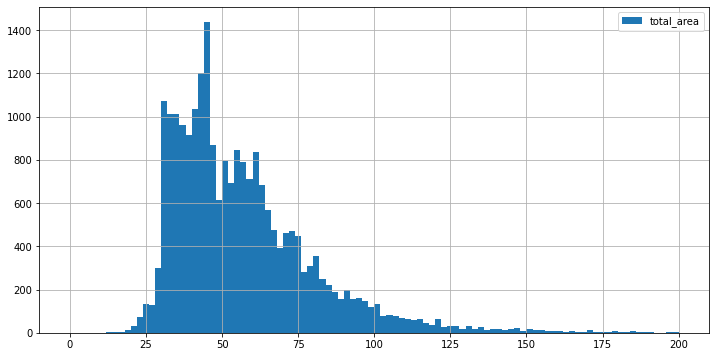

In [91]:
df['total_area'].hist(bins=100, legend=True, range=(0, 200), figsize=(12, 6))
plt.show()

Видим, что основная масса квартир имеет общую площадь 30-80 м.кв. На гистограмме наблюдаются пики и провалы количества квартир с определенной площадью. Вероятно, такая структура распределения связана с дискретностью количества комнат и ограниченностью (некоторыми нормами, ГОСТами, и т.п.) площадей жилых комнат, а значит и наличием выраженных интервалов значений общей площади. Отмечаются всплески количества квартир с площадью 30-45 м.кв. (однокомнатные), с площадью 50-65 м.кв. (2-комнатные) и 70-75 м.кв. (трехкомнатные).

<br>

### 4.1.2. Жилая площадь

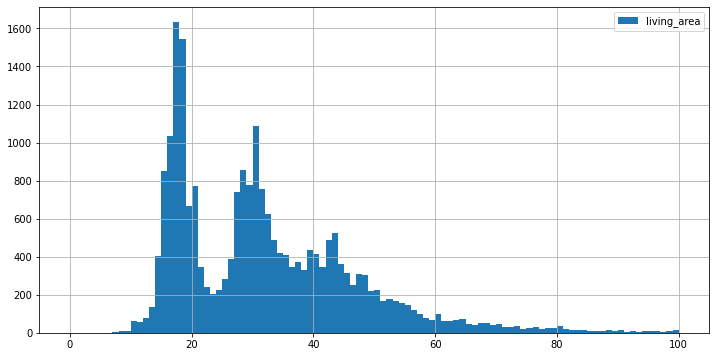

In [92]:
df['living_area'].hist(bins=100, legend=True, range=(0, 100), figsize=(12, 6))
plt.show()

На данной гистограмме предыдущее предположение (о дискретности интервалов площадей в следствие дискретности количества комнат) демонстрируется ещё ярче. Чётко видны группы квартир с 1 комнатой (жилая площадь 15-20 м.кв.), с 2 комнатами (25-35 м.кв.) и 3 комнатами (40-45 м.кв.).

<br>

### 4.1.3. Площадь кухни

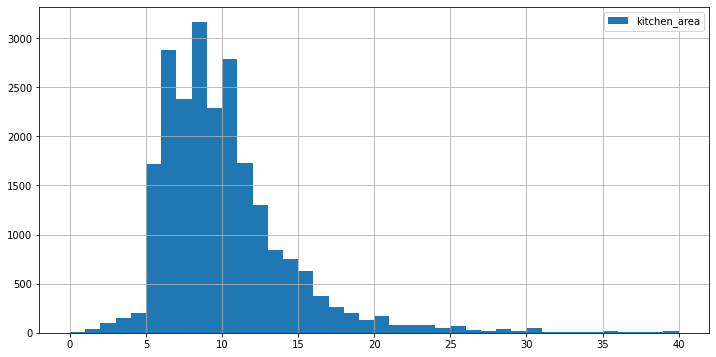

In [93]:
df['kitchen_area'].hist(bins=40, legend=True, range=(0, 40), figsize=(12, 6))
plt.show()

Видим, что основная масса квартир имеет площадь 5-12 м.кв. Больше всего квартир с площадью кухни 8-9 м.кв. Кухни до 5 м.кв. встречаются в датасете редко, как и кухни более 17-20 м.кв. Экстремально маленькие площади кухни до 2 м.кв. соответствуют квартирам с открытой планировкой и студиям.

<br>

### 4.1.4. Цена объекта

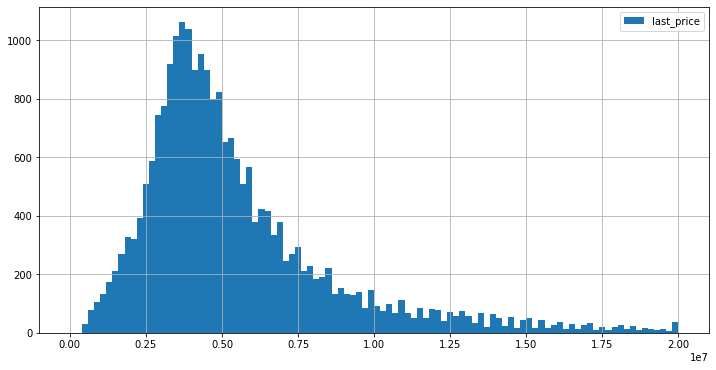

In [94]:
df['last_price'].hist(bins=100, legend=True, range=(0, 20000000), figsize=(12, 6))
plt.show()

В большинстве своём квартиры имеют цену от 2 до 7 млн.руб. От минимальной стоимости (430 тыс.руб.) до примерно 2 млн.руб. количество квартир растет практически линейно. Начиная с 2 млн.руб. рост количества квартир ускоряется и достигает максимума на отметке 3.5-4 млн.руб.

<br>

### 4.1.5. Количество комнат

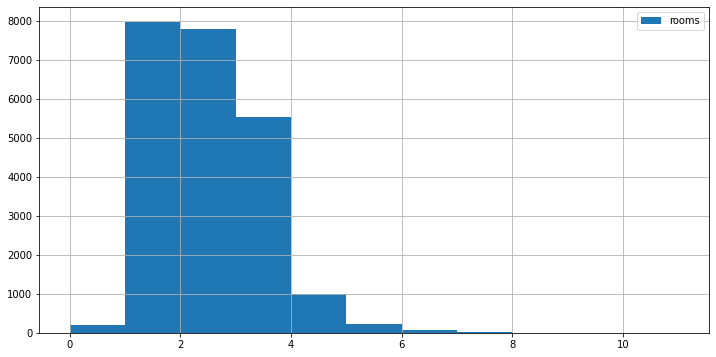

In [95]:
df['rooms'].hist(bins=11, legend=True, figsize=(12, 6))
plt.show()

Видим, что больше всего представлено 1-комнатных квартир (порядка 8000). Чуть меньше 2-комнатных (~7800). Около 5500 квартир - 3-комнатные. Остальных вариантов значительно меньше.

<br>

### 4.1.6. Высота потолков

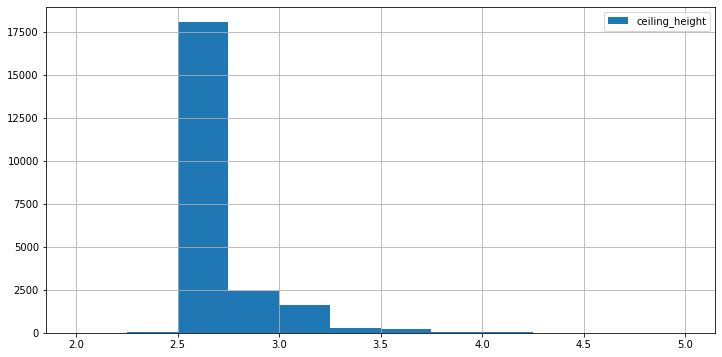

In [96]:
df['ceiling_height'].hist(bins=12, legend=True, range=(2, 5), figsize=(12, 6))
plt.show()

Самые распространённые значения для высоты потолка - от 2.5 до 2.75 м. Гораздо меньше квартир 2.75-3 м. Ещё меньше 3-3.25 м.

<br>

### 4.1.7. Этаж квартиры

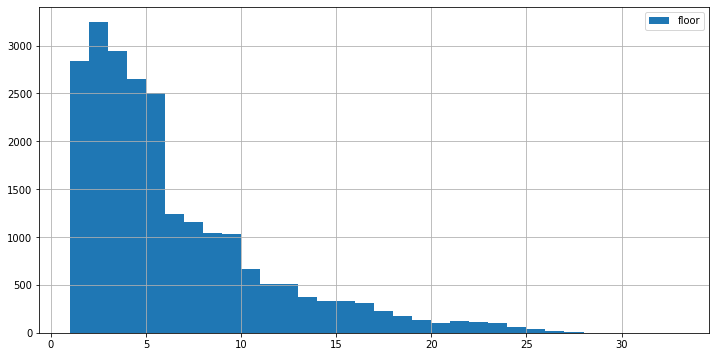

In [97]:
df['floor'].hist(bins=32, legend=True, figsize=(12, 6))
plt.show()

Видим интересную особенность - четкие "ступеньки" на гистограмме, объясняемые типовой застройкой и принятыми стандартами в строительстве. Первая выделяющаяся группа квартир расположена до 5 этажа включительно (помимо 1-2 этажных домов, в основном это 4- и 5-этажные дома советской постройки). Вторая группа квартир - до 9 этажа включительно (добавляются типовые панельные 9-этажки также советской постройки). Менее выражены, но также заметны "ступеньки" 10-этажек и 12-этажек.

<br>

### 4.1.8. Тип этажа квартиры

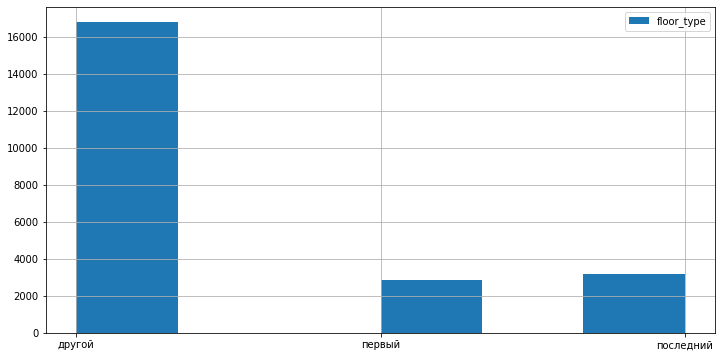

In [98]:
df['floor_type'].hist(bins=6, legend=True, figsize=(12, 6), xrot=0)
plt.show()

Больше всего продаётся квартир на любых этажах, кроме первого и последнего. Что логично, так как их в принципе гораздо больше.

<br>

### 4.1.9. Общее количество этажей в доме

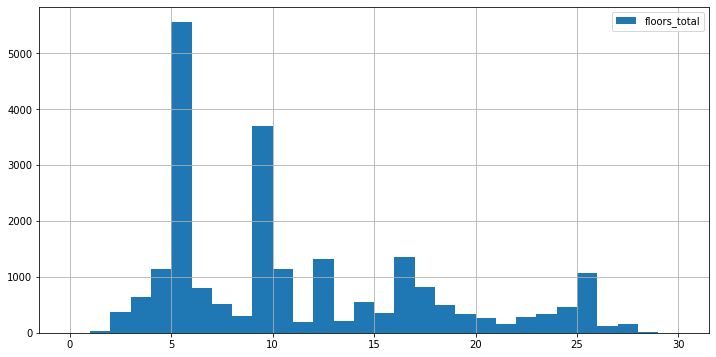

In [99]:
df['floors_total'].hist(bins=30, legend=True, range=(0, 30), figsize=(12, 6))
plt.show()

Здесь мы видим подтверждение предположения, сделанного на гистограмме распределения количества квартир в зависимости от этажа. Видны типовые дома с количеством 5, 9, 10, 12, 16, 25 этажей.

<br>

### 4.1.10. Расстояние до центра города в метрах

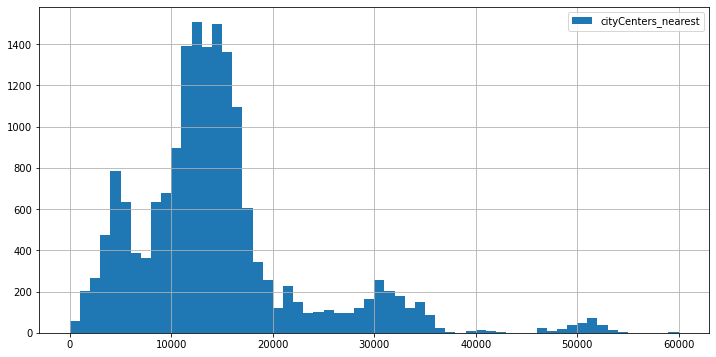

In [100]:
df['cityCenters_nearest'].hist(bins=60, legend=True, range=(0, 60000), figsize=(12, 6))
plt.show()

На данном распределении видим, что квартиры в датасете группируются внутри каких-то географических локаций. Видим несколько групп квартир, расположенных на расстояниях до 7 км от центра, 10-16 км. от центра (основная масса объявлений). Видна заметная группа квартир на расстоянии 30-35 км от центра. Также заметны группы на расстояниях 50 и 40 км.

<br>

### 4.1.11. Расстояние до ближайшего аэропорта

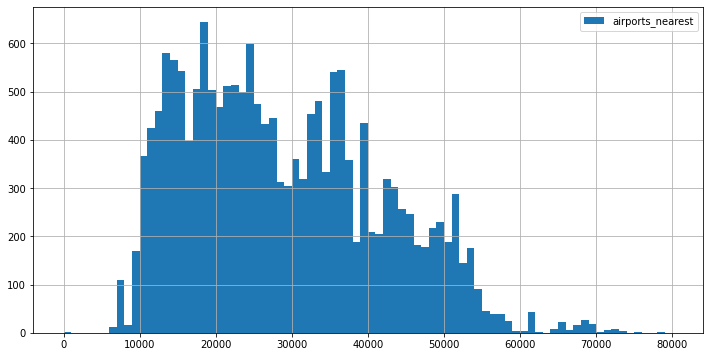

In [101]:
df['airports_nearest'].hist(bins=80, legend=True, range=(0, 80000), figsize=(12, 6))
plt.show()

Видно, что большинство квартир в датасете расположено более, чем в 10 км от аэропорта. Основное количество - на расстоянии 10-30 км. Дальше до 60 км. количество объявлений постепенно падает. На расстоянии более 60 км. квартир совсем мало.

<br>

### 4.1.12. Расстояние до ближайшего парка

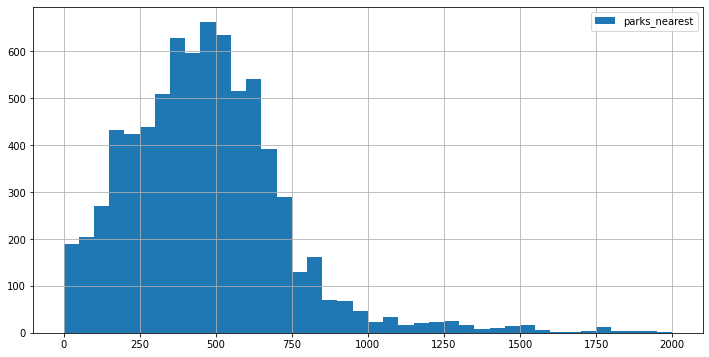

In [102]:
df['parks_nearest'].hist(bins=40, legend=True, range=(0, 2000), figsize=(12, 6))
plt.show()

На данной гистограмме видно, что Санкт-Петербург богат парковыми зонами. Практически все квартиры расположены от ближайшего парка на расстоянии менее 1 км. Больше всего квартир на расстоянии от парка 150-750 метров.

<br>

### 4.1.13. День недели публикации объявления

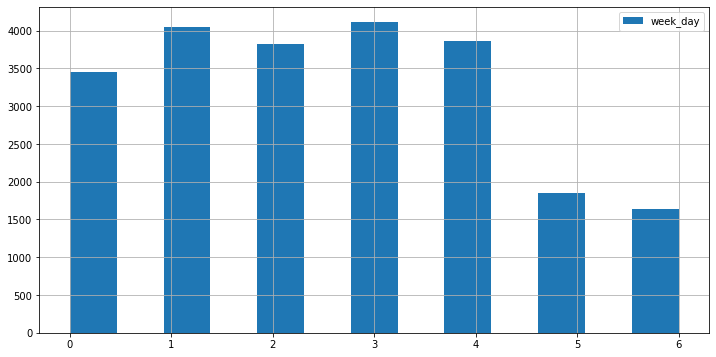

In [103]:
df['week_day'].hist(bins=13, legend=True, figsize=(12, 6))
plt.show()

Наблюдаем, что в основном объявления о продаже квартир подаются в будние дни (в среднем в будний день подано в два раза больше объявлений, чем в выходной). Также видно, что из всех будних дней в понедельник подавалось в среднем на 500 объявлений меньше.

<br>

### 4.1.14. Месяц публикации объявления

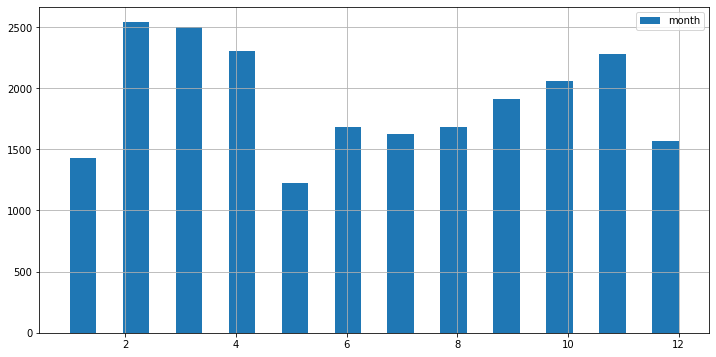

In [104]:
df['month'].hist(bins=23, legend=True, figsize=(12, 6))
plt.show()

Реже всего продают квартиры в декабре, январе, мае и в летние месяцы (вероятно, это связано с новогодними, майскими праздниками и летними отпусками). Получше ситуация в осенние месяцы. Больше всего объявлений подавалось с февраля по март.

<br>

### 4.1.15. Итоги анализа параметров квартиры

ВЫВОДЫ:

- Общая площадь: Основная масса квартир имеет общую площадь 30-80 м.кв. Отмечаются группы квартир с площадью 30-45 м.кв. (1-комнатные), с площадью 50-65 м.кв. (2-комнатные) и 70-75 м.кв. (трехкомнатные).

- Жилая площадь: Выделяются группы 1-комнатных квартир (жилая площадь 15-20 м.кв.), 2-комнатных (25-35 м.кв.) и 3-комнатных (40-45 м.кв.).

- Площадь кухни: В основной массе квартир кухня 5-12 м.кв. Больше всего квартир с кухней 8-9 м.кв. Кухни до 5 м.кв. встречаются редко, как и кухни > 17-20 м.кв. Экстремально маленькие кухни до 2 м.кв. в квартирах с открытой планировкой и студиях.

- Цена квартиры: В большинстве своём квартиры имеют цену от 2 до 7 млн.руб. От 430 тыс.руб. до ~2 млн.руб. количество квартир растет практически линейно. С 2 млн.руб. рост количества квартир ускоряется и достигает максимума на отметке 3.5-4 млн.руб.

- Количество комнат: 1-комнатных ~8000. 2-комнатных ~7800. 3-комнатных ~5500 квартир. Остальных вариантов значительно меньше.

- Высота потолков: Самые распространённые значения 2.5-2.75 м. Гораздо меньше квартир 2.75-3 м. Ещё меньше 3-3.25 м.

- Этаж квартиры: Несколько групп квартир. Первая - до 5 этажа включительно. Вторая группа - до 9 этажа включительно. Менее выражены, но также заметны группы до 10 и 12 этажей.

- Тип этажа: Меньше всего продаётся квартир на первом и последнем этаже.

- Общее количество этажей в доме: Выделяются типовые дома с количеством 5, 9, 10, 12, 16, 25 этажей.

- Расстояние до центра города в м.: Видны несколько групп квартир, расположенных на расстояниях до 7 км от центра, 10-16 км. (основная масса объявлений), 30-35 км от центра. Также заметны группы на расстояниях 50 и 40 км.

- Расстояние до ближайшего аэропорта: Большинство квартир расположено дальше 10 км от аэропорта. Основное количество - на расстоянии 10-30 км. Далее до 60 км количество объявлений постепенно падает. Более 60 км. - квартир совсем мало.

- Расстояние до ближайшего парка: Парковых зон много. Практически все квартиры менее чем в 1 км. от ближайшего парка. Больше всего квартир на расстоянии от парка 150-750 метров.

- День публикации объявления: В основном объявления подаются в будние дни (в среднем в будний день подано в два раза больше объявлений, чем в выходной). Из всех будних дней в понедельник подавалось в среднем на 500 объявлений меньше.

- Месяц публикации объявления: Реже всего продают квартиры в декабре, январе, мае и в летние месяцы (вероятно, это связано с новогодними, майскими праздниками и летними отпусками). Больше всего объявлений подавалось с февраля по март.

<br><br>

## 4.2. Изучим, как быстро продавались квартиры

Для начала проверим гипотезу о пропусках в столбце `days_exposition`, сформулированную в п. 2.16 (пропуски в тех объявлениях, в которых квартиры на момент выгрузки данных не были проданы). Выведем гистограмму распределения количества объявлений по годам для всего датасета и отдельно - для выборки из датасета только с пропущенными значениями в столбце `days_exposition`:

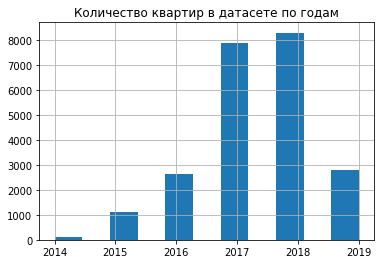

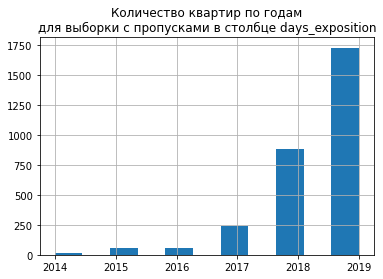

In [105]:
df['year'].hist(bins=11)
plt.title('Количество квартир в датасете по годам')
plt.show()

df[df['days_exposition'].isna()]['year'].hist(bins=11)
plt.title('Количество квартир по годам\nдля выборки с пропусками в столбце days_exposition')
plt.show()

Предположение, похоже, подтверждается. Не смотря на то, что в 2019 году было размещено не так много объявлений (менее 3000), большая часть из них (почти 1750) оказалась с пропусками в столбце `days_exposition`. То есть, судя по всему, эти квартиры не были проданы на конец периода датасета (на момент выгрузки данных). Ещё около 880 пропусков остались с 2018 года, 250 пропусков с 2017 года и по мелочи - с 2014-2016 гг (совсем долгие продажи).

Построим гистограмму для данных по срокам продажи:

In [106]:
# создадим переменную, запишем в неё значения из колонки `days_exposition`, удалим пропуски:
days = df['days_exposition']
days = days.dropna()

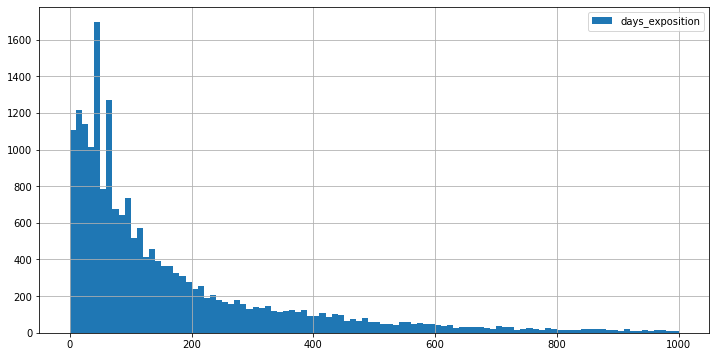

In [107]:
days.hist(bins=100, legend=True, range=(0, 1000), figsize=(12, 6))
plt.show()

На гистограмме наблюдаются ярко выраженные пики. Рассмотрим их ближе:

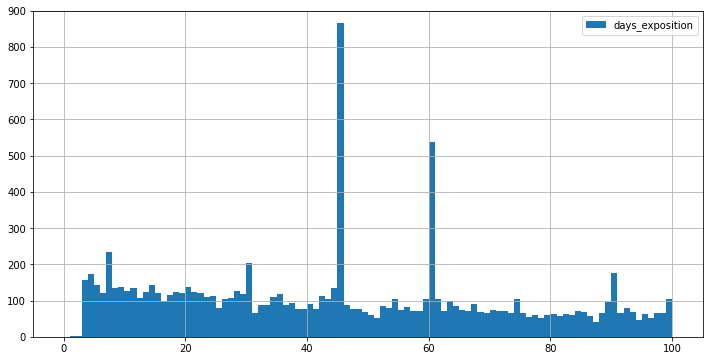

In [108]:
days.hist(bins=100, legend=True, range=(0, 100), figsize=(12, 6))
plt.ylim(0, 900)
plt.show()

Видны отчетливые всплески количества объявлений, "провисевших" 7, 30, 45, 60, 74 и 90 дней. Особенно много объявлений со сроком размещения 45 дней (более 850 квартир) и 60 дней (около 550 квартир). Очевидно, это не похоже на обычное совпадение, вызванное естественными причинами. Вероятно это связано с техническими особенностями платформы, где были размещены объявления. Возможно, эти объявления были размещены на платной основе и удалены по истечении оплаченного периода. Или же, как вариант, это один из элементов тактики риэлторов.

Исправим эти аномальные значения количества дней продажи: Полностью удалять их нельзя, иначе получим провалы на гистограмме в этих значениях. Нужно оставить для каждой аномалии такое количество значений, чтобы оно не выделялось на фоне соседей, а остальные уже удалить. Например, рассчитать и оставить среднее количество между левым и правым соседом на гистограмме (значением количества дней):

In [109]:
anomals = [7, 30, 45, 60, 74, 90]
for anomal in anomals:
    day = days[days == anomal]
    new_value = int((len(days[days == anomal - 1]) + len(days[days == anomal + 1])) / 2)
    day[new_value:] = None
    days[days == anomal] = day
days = days.dropna()

Проверим, что аномалии удалены. Выведем снова гистограмму в том же масштабе:

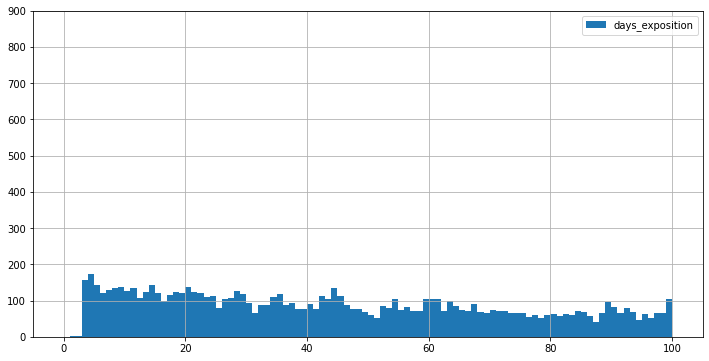

In [110]:
days.hist(bins=100, legend=True, range=(0, 100), figsize=(12, 6))
plt.ylim(0, 900)
plt.show()

Построим диаграмму размаха и рассчитаем основные описательные статистики:

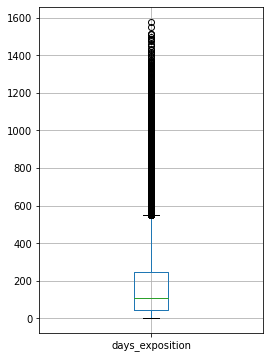

In [111]:
days.plot(kind='box', grid=True, figsize=(4, 6))
#plt.ylim(0, 550)
plt.show()

In [112]:
days.describe()

count    18292.000000
mean       188.018806
std        221.573907
min          1.000000
25%         43.000000
50%        107.000000
75%        245.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [113]:
outliers_n = len(days[days > 550])
print(f"Количество выбросов в столбце `days_exposition` (более 550 дней): {outliers_n} ({outliers_n / len(days):.1%})")     

Количество выбросов в столбце `days_exposition` (более 550 дней): 1364 (7.5%)


Видим, что срок продажи квартиры характерен в границах от 1 до 550 дней. Свыше 550 дней уже выбросы и их около 7.5%, что приводит к тому, что среднее значение по столбцу в 1.75 раз превышает медиану.

Судя по графикам и описательным статистикам для данной переменной, обычно продажа квартиры занимает около 3.5 месяцев (медиана 107 дней). Быстрыми можно считать продажи квартиры менее чем за 1.5 месяца (1-й квартиль, 43 дня), а необычно долгими - более чем за 8 месяцев (3-й квартиль, 245 дней)

ВЫВОДЫ:

- Проверена гипотеза о пропусках в столбце `days_exposition`: пропуски наблюдаются для тех квартир, которые на момент выгрузки данных не были проданы.

- Выявлена особенность портала по продаже квартир - объявления иногда размещаются на определенный срок (7, 30, 45, 60, 74, 90 дней).

- Установлено, что срок продажи квартиры характерен в границах от 1 до 550 дней. Свыше 550 дней уже выбросы и их около 7.5%, что приводит к тому, что среднее значение по столбцу в 1.75 раз превышает медиану.

- Обычно продажа квартиры занимает около 3.5 месяцев.

- Быстрыми можно считать продажи квартиры менее чем за 1.5 месяца, а необычно долгими - более чем за 8 месяцев

<br><br>

## 4.3. Изучим влияние на стоимость объекта следующих факторов:

### 4.3.1. Общая площадь

Построим диаграмму рассеяния и рассчитаем коэффициент корреляции Пирсона для цены объекта и общей площади:

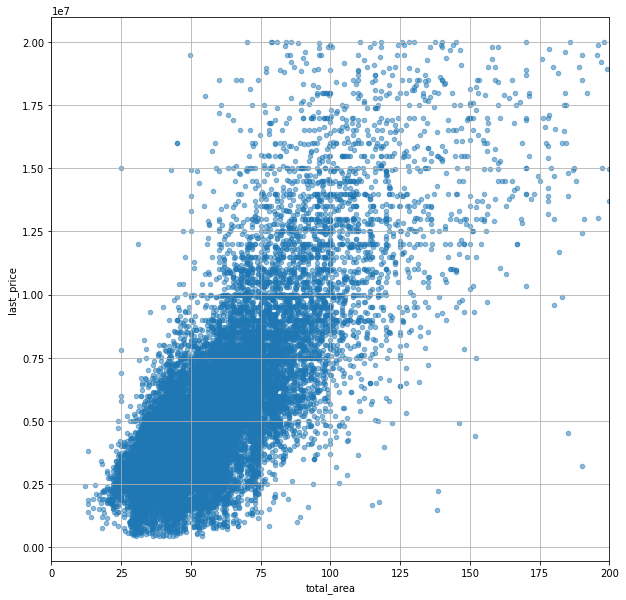

In [114]:
df.plot(x='total_area', y='last_price', grid=True, figsize=(10, 10), kind='scatter', alpha=0.5)
plt.xlim(0, 200)
plt.show()

In [115]:
df['total_area'].corr(df['last_price'])

0.7714228252054146

На графике наблюдаем прямую линейную взаимосвязь между ценой квартиры и ее общей площадью - при увеличении площади увеличивается и цена. Коэффициент корреляции Пирсона более 0.77 это подтверждает и указывает на достаточно высокую степень взаимосвязи переменных.

<br>

### 4.3.2. Жилая площадь

Построим диаграмму рассеяния и рассчитаем коэффициент корреляции Пирсона для цены объекта и жилой площади:

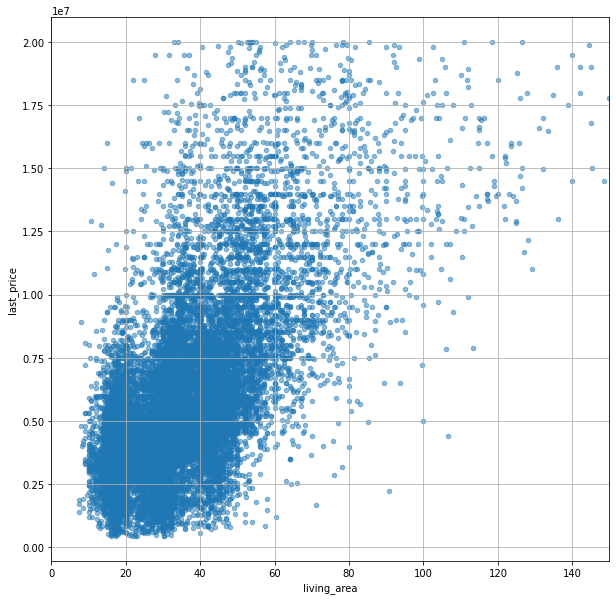

In [116]:
df.plot(x='living_area', y='last_price', grid=True, figsize=(10, 10), kind='scatter', alpha=0.5)
plt.xlim(0, 150)
plt.show()

In [117]:
df['living_area'].corr(df['last_price'])

0.6707415924340968

Наблюдаем прямую линейную взаимосвязь между ценой квартиры и ее жилой площадью - при увеличении площади увеличивается и цена. Коэффициент корреляции Пирсона более 0.67 это подтверждает и указывает на заметную степень взаимосвязи переменных.

<br>

### 4.3.3. Площадь кухни

Построим диаграмму рассеяния и рассчитаем коэффициент корреляции Пирсона для цены объекта и площади кухни:

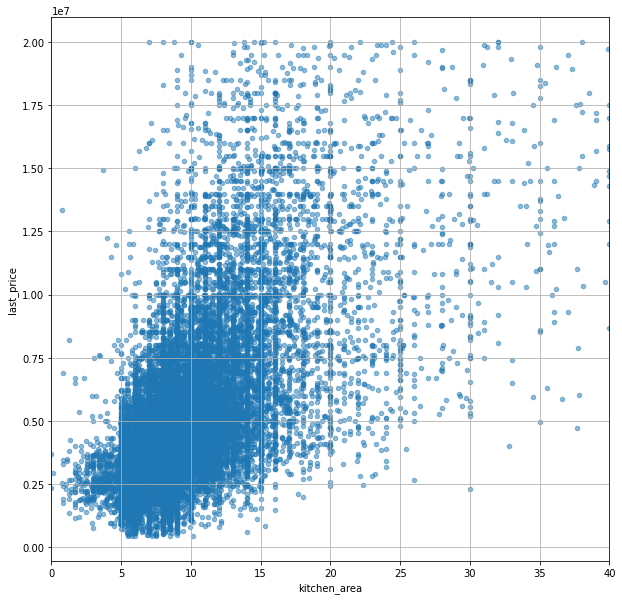

In [118]:
df.plot(x='kitchen_area', y='last_price', grid=True, figsize=(10, 10), kind='scatter', alpha=0.5)
plt.xlim(0, 40)
plt.show()

In [119]:
df['kitchen_area'].corr(df['last_price'])

0.5939770946178109

Наблюдаем прямую линейную взаимосвязь между ценой квартиры и площадью кухни - при увеличении площади увеличивается и цена. Коэффициент корреляции Пирсона более 0.59 это подтверждает и указывает на заметную степень взаимосвязи переменных.

<br>

### 4.3.4. Количество комнат

Вычислим среднюю стоимость квартиры для каждого значения количества комнат и визуализируем в виде столбчатой диаграммы:

In [120]:
rooms_price = pd.pivot_table(df, index='rooms', values='last_price', aggfunc=['mean', 'count']).sort_index()
rooms_price.columns = ['last_price', 'count']
rooms_price

,last_price,count
rooms,,
0,2.992508e+06,196
1,3.809630e+06,7960
2,5.352347e+06,7791
3,6.970130e+06,5531
4,8.918333e+06,1002
5,1.131604e+07,224
6,1.413857e+07,61
7,1.530429e+07,21
8,1.726000e+07,5


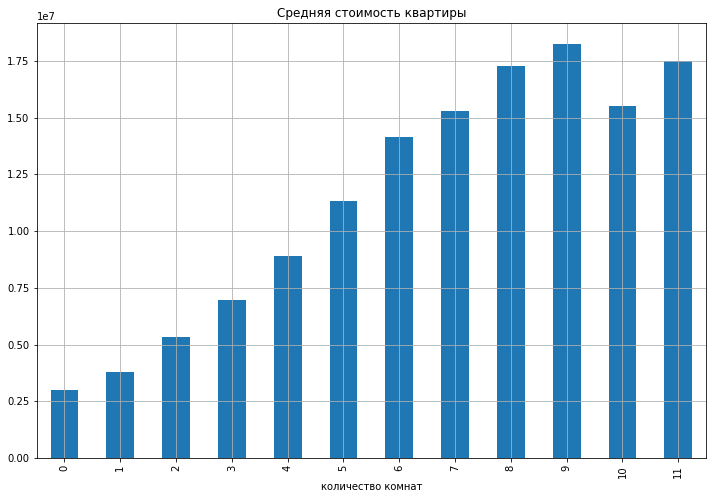

In [121]:
rooms_price.plot(y='last_price', kind='bar', xlabel='количество комнат', grid=True, legend=False, figsize=(12, 8))
plt.title('Средняя стоимость квартиры')
plt.show()

Построенная столбчатая диаграмма наглядно показывает линейную взаимосвязь средней цены квартиры и количеством комнат в ней. Последние два столбца соответствуют всего двум квартирам (одна с 10 и одна 11 комнатами) и не показательны.

<br>

### 4.3.5. Тип этажа (первый, последний, другой)

Вычислим среднюю стоимость квартиры для каждого типа этажа и визуализируем в виде линейчатой диаграммы:

In [122]:
floor_type_price = pd.pivot_table(df, index='floor_type', values='last_price', aggfunc=['mean', 'count'])
floor_type_price.columns = ['last_price', 'count']
floor_type_price = floor_type_price.sort_values(by='last_price')
floor_type_price

,last_price,count
floor_type,,
первый,4.404706e+06,2841
последний,5.155997e+06,3159
другой,5.666695e+06,16795


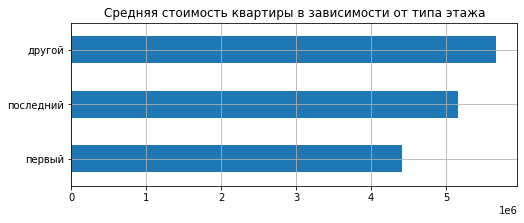

In [123]:
floor_type_price.plot(y='last_price', kind='barh', xlabel='', grid=True, legend=False, figsize=(8, 3))
plt.title('Средняя стоимость квартиры в зависимости от типа этажа')
plt.show()

Данная линейчатая диаграмма показывает, что квартиры на первом и последем этажах в среднем дешевле квартир на любом другом этаже. Квартира на первом этаже ценится меньше всего. Средняя цена на неё меньше чем у квартиры на другом этаже на 1.25 млн. руб. А средняя цена квартиры на последнем этаже меньше чем у квартиры на другом этаже на 0.5 млн. руб.

Проверим, сохраняется ли эта закономерность из года в год, или это просто случайное стечение обстоятельств. Добавим в сводную таблицу разбивку по годам и визуализируем:

In [124]:
floor_type_price_by_year = pd.pivot_table(df, index='floor_type', columns='year', values='last_price').sort_index()
floor_type_price_by_year

year,2014,2015,2016,2017,2018,2019
floor_type,,,,,,
другой,8.409996e+06,6.534340e+06,5.680515e+06,5.555249e+06,5.516534e+06,5.973471e+06
первый,5.167110e+06,4.909047e+06,4.486741e+06,4.309650e+06,4.264963e+06,4.761638e+06
последний,9.329595e+06,5.526768e+06,5.235044e+06,5.106055e+06,5.020460e+06,5.292284e+06


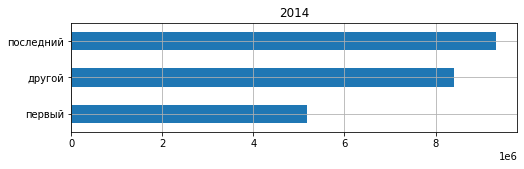

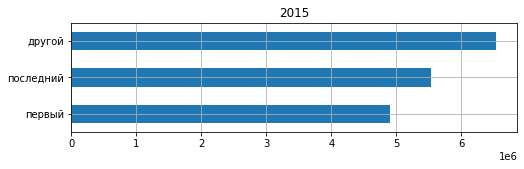

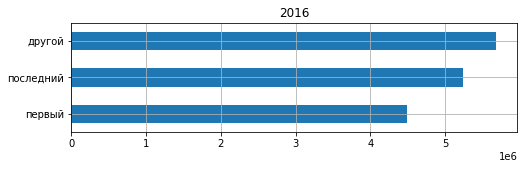

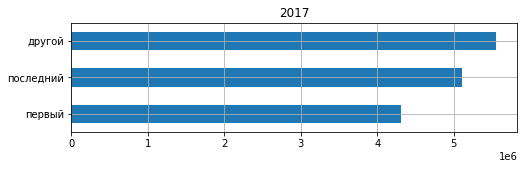

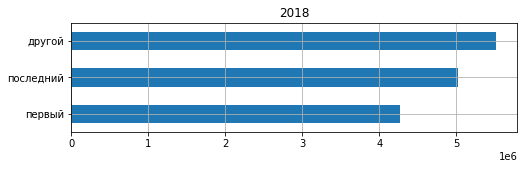

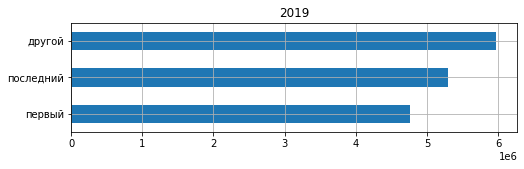

In [125]:
for year in floor_type_price_by_year.columns:
    floor_type_price_by_year.sort_values(by=year).plot(y=year, kind='barh', xlabel='', grid=True, legend=False, figsize=(8, 2))
    plt.title(str(year))
    plt.show()

Видим, что выявленная закономерность наблюдается из года в год (за исключением 2014, где совсем мало объявлений), что подтверждает зависимость средней цены квартиры от типа этажа.

<br>

### 4.3.6. День недели размещения объявления

Вычислим среднюю стоимость квартиры для каждого дня недели размещения объявления и визуализируем в виде столбчатой диаграммы:

In [126]:
day_price = pd.pivot_table(df, index='week_day', values='last_price', aggfunc=['mean', 'count']).sort_index()
day_price.columns = ['last_price', 'count']
day_price

,last_price,count
week_day,,
0,5.411395e+06,3456
1,5.490307e+06,4046
2,5.522426e+06,3826
3,5.540609e+06,4112
4,5.380207e+06,3861
5,5.259868e+06,1857
6,5.257064e+06,1637


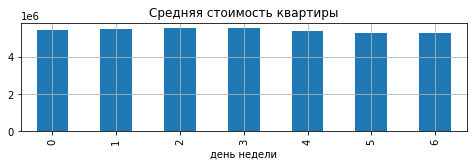

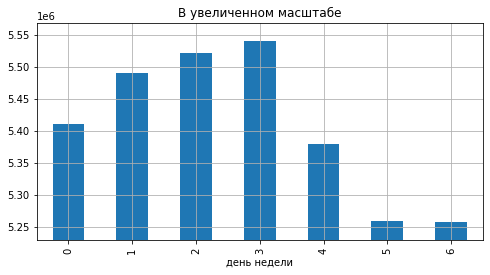

In [127]:
day_price.plot(y='last_price', kind='bar', xlabel='день недели', grid=True, legend=False, figsize=(8, 2))
plt.title('Средняя стоимость квартиры')
plt.show()

day_price.plot(y='last_price', kind='bar', xlabel='день недели', grid=True, legend=False, figsize=(8, 4))
plt.title('В увеличенном масштабе')
delta = (day_price['last_price'].max() - day_price['last_price'].min()) * 0.1
plt.ylim(day_price['last_price'].min() - delta, day_price['last_price'].max() + delta)
plt.show()

Первичный анализ дней недели размещения объявлений показал, что дороже всего выставляются квартиры среди недели - в среду и четверг, а дешевле всего - в субботу и воскресенье. Так средняя цена на квартиры, размещённые в четверг почти на 280 тысяч руб. дороже тех, что выставлены на продажу в воскресенье.

Проверим, сохраняется ли эта закономерность из года в год, или это просто случайное стечение обстоятельств. Добавим в сводную таблицу разбивку по годам и визуализируем в увеличенном масштабе:

In [128]:
day_price_by_year = pd.pivot_table(df, index='week_day', columns='year', values='last_price').sort_index()
day_price_by_year

year,2014,2015,2016,2017,2018,2019
week_day,,,,,,
0,6.627200e+06,6.107979e+06,5.401302e+06,5.412350e+06,5.205978e+06,5.740623e+06
1,1.049569e+07,5.773160e+06,5.478005e+06,5.380365e+06,5.411810e+06,5.622952e+06
2,5.863870e+06,6.204480e+06,5.550885e+06,5.309365e+06,5.415012e+06,6.037302e+06
3,9.408338e+06,6.636166e+06,5.851350e+06,5.411147e+06,5.248828e+06,5.840967e+06
4,5.522778e+06,6.239455e+06,5.347804e+06,5.299746e+06,5.269997e+06,5.737074e+06
5,8.815312e+06,5.337522e+06,5.078545e+06,5.195162e+06,5.237561e+06,5.603648e+06
6,6.434667e+06,6.493630e+06,4.991128e+06,5.307392e+06,5.173735e+06,5.195170e+06


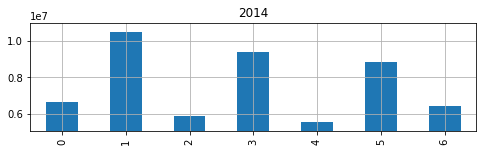

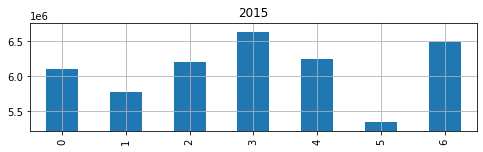

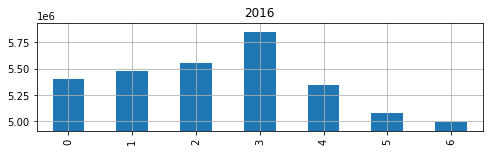

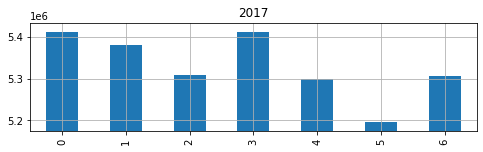

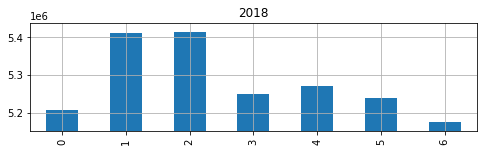

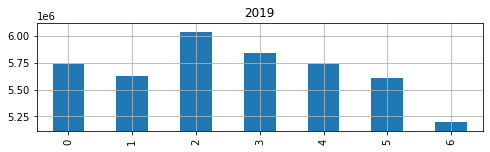

In [129]:
for year in day_price_by_year.columns:
    day_price_by_year.plot(y=year, kind='bar', xlabel='', grid=True, legend=False, figsize=(8, 2))
    plt.title(str(year))
    delta = (day_price_by_year[year].max() - day_price_by_year[year].min()) * 0.1
    plt.ylim(day_price_by_year[year].min() - delta, day_price_by_year[year].max() + delta)
    plt.show()

Видим, что из года в год никакой закономерности в распределении средней цены на квартиры по дням недели не наблюдается.

Проверим, на примере одного года, есть ли какие-то закономерности в распределении средней цены на квартиры по дням недели, повторяющиеся каждый месяц. Зафиксируем год (например, 2018), добавим в сводную таблицу разбивку по месяцам и визуализируем в увеличенном масштабе:

In [130]:
day_price_by_month = pd.pivot_table(df.query('year == 2018'), index='week_day', 
                                    columns='month', values='last_price').sort_index()
day_price_by_month

month,1,2,3,4,5,6,7,8,9,10,11,12
week_day,,,,,,,,,,,,
0,5.267501e+06,4.807662e+06,4.971623e+06,4.869258e+06,5.343000e+06,4.548524e+06,5.254513e+06,5.971213e+06,4.931676e+06,5.479972e+06,5.271987e+06,5.464453e+06
1,4.937658e+06,5.474223e+06,4.934668e+06,4.984883e+06,5.263194e+06,5.202516e+06,5.552057e+06,5.104763e+06,5.809430e+06,5.206445e+06,6.046919e+06,6.063733e+06
2,5.001837e+06,5.015415e+06,4.984146e+06,6.368373e+06,5.464760e+06,4.677022e+06,5.961482e+06,5.429282e+06,5.582228e+06,5.683840e+06,5.484110e+06,5.487608e+06
3,4.678378e+06,5.366079e+06,5.038343e+06,4.689137e+06,5.910232e+06,5.027494e+06,5.175917e+06,5.012265e+06,5.018142e+06,5.985640e+06,5.487274e+06,5.062777e+06
4,4.793387e+06,4.954208e+06,5.193221e+06,5.607937e+06,5.190577e+06,5.132700e+06,5.294283e+06,5.384869e+06,5.841801e+06,5.306494e+06,5.538642e+06,5.084284e+06
5,5.437310e+06,5.440150e+06,4.934690e+06,5.055000e+06,6.082917e+06,5.287400e+06,5.513151e+06,5.249042e+06,4.722154e+06,5.470150e+06,5.130983e+06,5.542499e+06
6,5.184477e+06,4.567569e+06,5.313894e+06,5.078616e+06,4.262500e+06,4.937326e+06,4.983349e+06,5.114067e+06,5.426236e+06,4.468512e+06,5.634621e+06,6.517983e+06


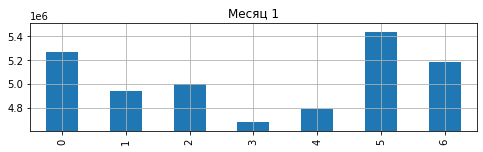

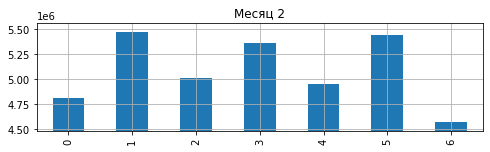

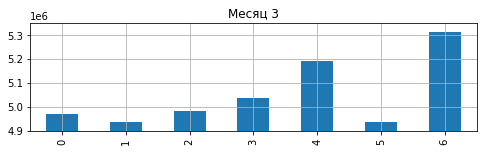

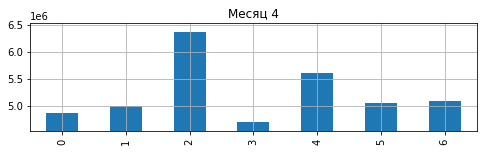

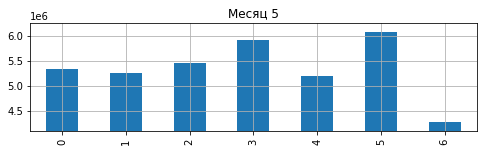

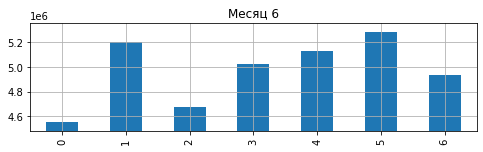

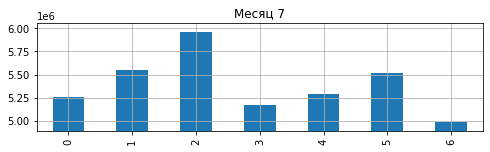

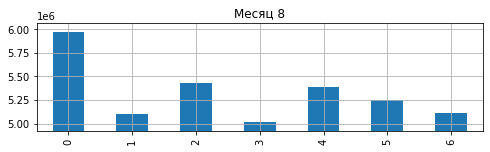

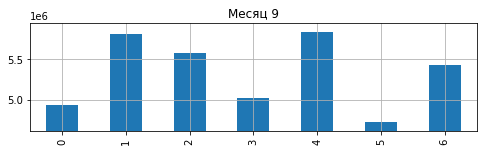

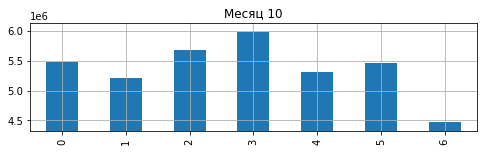

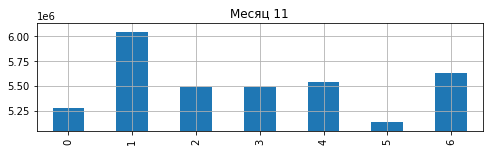

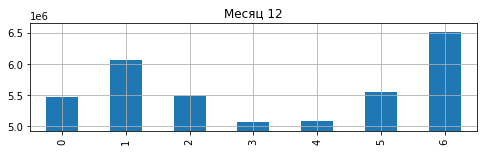

In [131]:
for month in day_price_by_month.columns:
    day_price_by_month.plot(y=month, kind='bar', xlabel='', grid=True, legend=False, figsize=(8, 2))
    plt.title('Месяц ' + str(month))
    delta = (day_price_by_month[month].max() - day_price_by_month[month].min()) * 0.1
    plt.ylim(day_price_by_month[month].min() - delta, day_price_by_month[month].max() + delta)
    plt.show()

Видим, что из месяца в месяц никакой закономерности в распределении средней цены на квартиры по дням недели также не наблюдается.

Зависимости цены квартиры от дня недели размещения объявления не обнаружено.

<br>

### 4.3.7. Месяц размещения объявления

Вычислим среднюю стоимость квартиры для каждого месяца размещения объявления и визуализируем в виде столбчатой диаграммы:

In [132]:
month_price = pd.pivot_table(df, index='month', values='last_price', aggfunc=['mean', 'count']).sort_index()
month_price.columns = ['last_price', 'count']
month_price

,last_price,count
month,,
1,5.396742e+06,1425
2,5.421687e+06,2539
3,5.430061e+06,2500
4,5.568262e+06,2301
5,5.426946e+06,1227
6,5.214053e+06,1682
7,5.434617e+06,1626
8,5.443500e+06,1683
9,5.570871e+06,1914


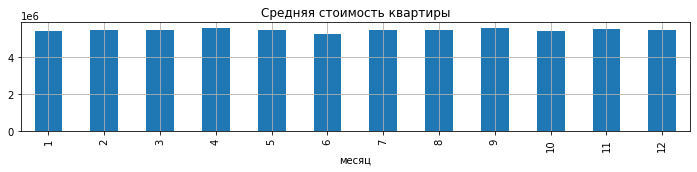

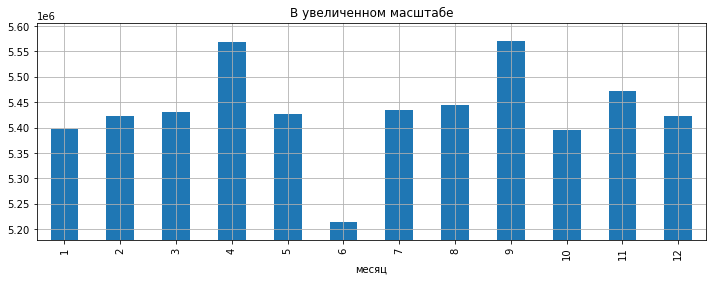

In [133]:
month_price.plot(y='last_price', kind='bar', xlabel='месяц', grid=True, legend=False, figsize=(12, 2))
plt.title('Средняя стоимость квартиры')
plt.show()

month_price.plot(y='last_price', kind='bar', xlabel='месяц', grid=True, legend=False, figsize=(12, 4))
plt.title('В увеличенном масштабе')
delta = (month_price['last_price'].max() - month_price['last_price'].min()) * 0.1
plt.ylim(month_price['last_price'].min() - delta, month_price['last_price'].max() + delta)
plt.show()

Первичный анализ месяцев размещения объявлений показал, что в среднем квартиры выставляются по цене 5.4-5.46 млн. руб. почти в любой месяц. Однако в апреле и сентябре квартиры выставлялись на 150 тысяч дороже этих значений, а в июне - на 200 тысяч руб. дешевле.

Проверим, сохраняется ли эта закономерность из года в год, или это просто случайное стечение обстоятельств. Добавим в сводную таблицу разбивку по годам и визуализируем в увеличенном масштабе:

In [134]:
month_price_by_year = pd.pivot_table(df, index='month', columns='year', values='last_price').sort_index()
month_price_by_year

year,2014,2015,2016,2017,2018,2019
month,,,,,,
1,NaN,7.026636e+06,5.701241e+06,5.456263e+06,5.026122e+06,5.570568e+06
2,NaN,6.513026e+06,5.340366e+06,5.517162e+06,5.192427e+06,5.829009e+06
3,NaN,6.157933e+06,5.520750e+06,5.490957e+06,5.041485e+06,5.739282e+06
4,NaN,6.414947e+06,5.438247e+06,5.438175e+06,5.288638e+06,5.754755e+06
5,NaN,5.779472e+06,5.490334e+06,5.314981e+06,5.403284e+06,5.710141e+06
6,NaN,5.836607e+06,5.284119e+06,5.253993e+06,5.000117e+06,NaN
7,NaN,6.066490e+06,5.025897e+06,5.452035e+06,5.422758e+06,NaN
8,NaN,6.472475e+06,4.963247e+06,5.495313e+06,5.336377e+06,NaN
9,NaN,7.405104e+06,6.086362e+06,5.478467e+06,5.394675e+06,NaN


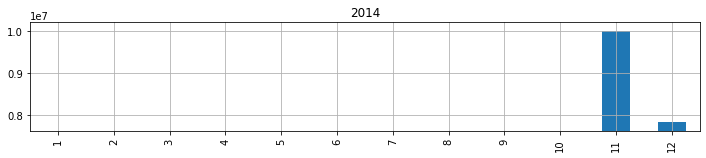

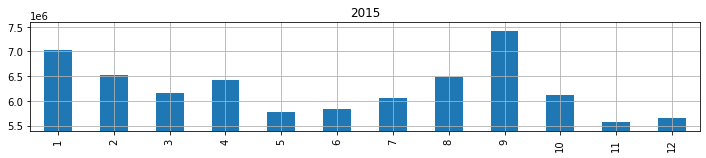

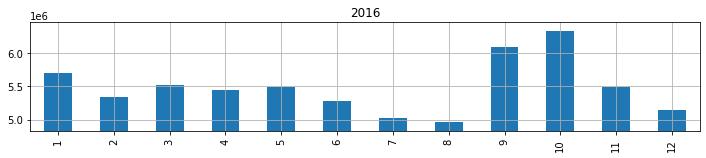

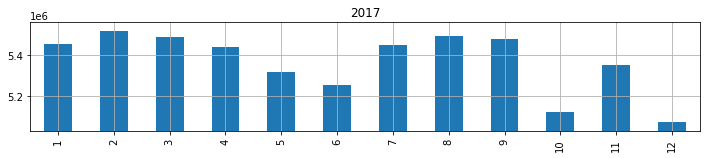

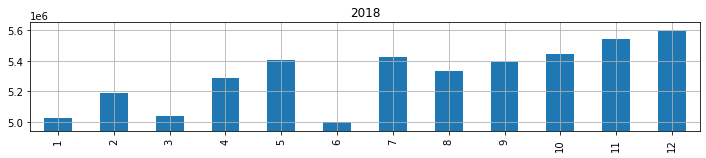

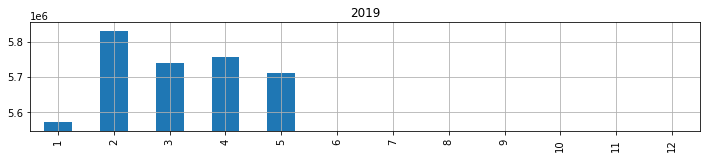

In [135]:
for year in month_price_by_year.columns:
    month_price_by_year.plot(y=year, kind='bar', xlabel='', grid=True, legend=False, figsize=(12, 2))
    plt.title(str(year))
    delta = (month_price_by_year[year].max() - month_price_by_year[year].min()) * 0.1
    plt.ylim(month_price_by_year[year].min() - delta, month_price_by_year[year].max() + delta)
    plt.show()

Видим, что из года в год никакой закономерности в распределении средней цены на квартиры по месяцам не наблюдается.

Зависимости цены квартиры от месяца размещения объявления не обнаружено.

<br>

### 4.3.8. Год размещения объявления

Вычислим среднюю стоимость квартиры для каждого года размещения объявления и визуализируем в виде столбчатой диаграммы:

In [136]:
year_price = pd.pivot_table(df, index='year', values='last_price', aggfunc=['mean', 'count']).sort_index()
year_price.columns = ['last_price', 'count']
year_price

,last_price,count
year,,
2014,8.106958e+06,115
2015,6.151926e+06,1102
2016,5.455151e+06,2635
2017,5.342018e+06,7865
2018,5.293286e+06,8292
2019,5.736098e+06,2786


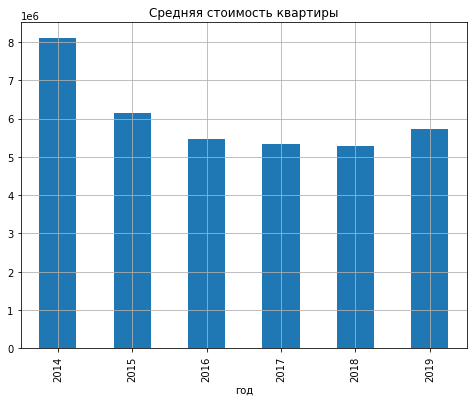

In [137]:
year_price.plot(y='last_price', kind='bar', xlabel='год', grid=True, legend=False, figsize=(8, 6))
plt.title('Средняя стоимость квартиры')
plt.show()

Анализ годов размещения объявлений показал, что в среднем самые дорогие квартиры выставлялись на продажу в 2014 году. Средняя цена на них превышала 8 млн. руб. Однако, в этом году было размещено всего 115 объявлений, поэтому данная цифра не совсем показательна. В дальнейшем из года в год средняя цена на квартиры снижалась вплоть до 2019 года. (2015 - 6.15 млн. руб, 2016 - 5.46 млн. руб., 2017 - 5.34 млн. руб., 2018 - 5.29 млн. руб., 2019 - 5.74 млн. руб.)

<br>

### 4.3.9. Подведём итоги анализа влияния на цену квартиры различных параметров

ВЫВОДЫ:

- Общая площадь - выявлена прямая сильная взаимосвязь с ценой квартиры, (к-т корреляции Пирсона 0.77)
- Жилая площадь - выявлена прямая заметная взаимосвязь с ценой квартиры, (к-т корреляции Пирсона 0.67)
- Площадь кухни - выявлена прямая заметная взаимосвязь с ценой квартиры, (к-т корреляции Пирсона 0.59)
- Количество комнат - выявлена прямая взаимосвязь с ценой квартиры
- Тип этажа - квартира на первом этаже ценится меньше всего (средняя цена меньше на 1.25 млн. руб.) А средняя цена квартиры на последнем этаже меньше на 0.5 млн. руб чем у квартир на других этажах
- День недели - взаимосвязи с ценой квартиры не выявлено
- Месяц - взаимосвязи с ценой квартиры не выявлено
- Год - из года в год средняя цена на квартиры снижалась вплоть до 2019 года. (2015 - 6.15 млн. руб, 2016 - 5.46 млн. руб., 2017 - 5.34 млн. руб., 2018 - 5.29 млн. руб., 2019 - 5.74 млн. руб.)

На цену квартиры сильно влияют такие параметры, как площадь, количество комнат и этаж расположения. Влияние дня недели и месяца размещения объявления на цену квартиры не выявлено. Влияние года размещения объявления на цену квартиры зависит скорее от внешних факторов (от экономической ситуации в стране, например).

<br><br>

## 4.4. Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра

Сначала создадим список ТОП-10 населенных пунктов с наибольшим количеством объявлений:

In [138]:
locality_top10 = list(df['locality_name'].value_counts().head(10).index)
locality_top10

['Санкт-Петербург',
 'посёлок Мурино',
 'посёлок Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'посёлок Парголово',
 'деревня Кудрово',
 'Гатчина',
 'Выборг']

Затем вычислим среднюю цену квадратного метра для каждого населенного пункта из нашего списка ТОП-10 и визуализируем в виде линейчатой диаграммы:

In [139]:
square_meter_price_top10 = pd.pivot_table(df.query('locality_name in @locality_top10'),
                                          index='locality_name', values='square_meter_price', aggfunc=['mean', 'count'])
square_meter_price_top10.columns = ['square_meter_price', 'count']
square_meter_price_top10 = square_meter_price_top10.sort_values(by='square_meter_price')
square_meter_price_top10.sort_values(by='square_meter_price', ascending=False)

,square_meter_price,count
locality_name,,
Санкт-Петербург,108681.118266,15017
Пушкин,101826.053073,358
деревня Кудрово,92418.939189,296
посёлок Парголово,90211.515337,326
посёлок Мурино,85700.211679,548
посёлок Шушары,78687.492027,439
Колпино,75332.866469,337
Гатчина,69100.215827,278
Всеволожск,67268.354756,389


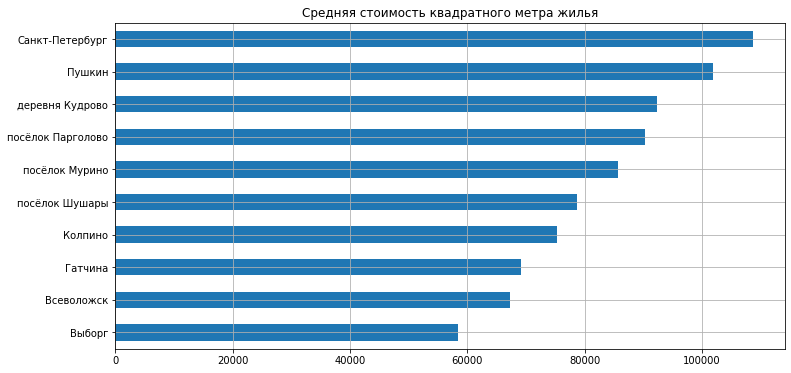

In [140]:
square_meter_price_top10.plot(y='square_meter_price', kind='barh', xlabel='', grid=True, legend=False, figsize=(12, 6))
plt.title('Средняя стоимость квадратного метра жилья')
plt.show()

ВЫВОДЫ:

Выделили ТОП-10 населенных пунктов по количеству размещённых объявлений (Санкт-Петербург, посёлок Мурино, посёлок Шушары, Всеволожск, Пушкин, Колпино, посёлок Парголово, деревня Кудрово, Гатчина, Выборг). Больше всего объявлений размещено в Санкт-Петербурге (15017 объявлений), меньше всего - в Выборге (215).

Для каждого населенного пункта из списка ТОП-10 рассчитали среднюю стоимость квадратного метра жилья. Самая высокая стоимость в Санкт-Петербурге (108681 р./м.кв.) и в Пушкине (101826 р./м.кв.). А самая низкая стоимость в Выборге (58343 р./м.кв.) и Всеволожске (67268 р./м.кв.)

<br><br>

## 4.5. Для квартир в Санкт-Петербурге опишем, как стоимость объектов зависит от расстояния до центра города. Вычислим среднюю цену каждого километра

Вычислим сначала для всех населенных пунктов из датасета среднюю цену квартиры на каждом километре от центра Санкт-Петербурга. Посмотрим, как ведет себя цена при удалении от центра города и визуализируем в виде графика:

In [141]:
distance_price = pd.pivot_table(df, index='cityCenter_distance', values='last_price', aggfunc=['mean', 'count'])
distance_price.columns = ['price_mean', 'count']
distance_price

,price_mean,count
cityCenter_distance,,
0,1.019857e+07,14
1,1.052448e+07,154
2,1.006261e+07,257
3,9.026695e+06,322
4,9.342067e+06,618
5,9.385708e+06,783
6,8.612033e+06,507
7,7.967470e+06,339
8,7.853365e+06,553


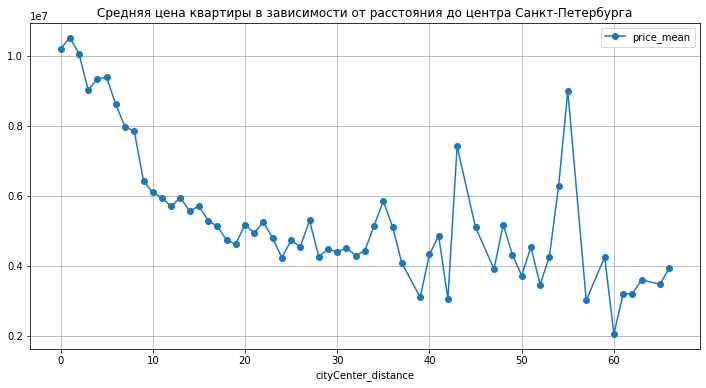

In [142]:
distance_price['price_mean'].plot(legend=True, figsize=(12, 6), style='o-', grid=True)
plt.title('Средняя цена квартиры в зависимости от расстояния до центра Санкт-Петербурга')
plt.show()

Видно, что чем дальше от центра города, тем больше наблюдается "шумов" и неоднородностей в графике. Это явление напрямую связано с малым количеством квартир в датасете, расположенных на таком расстоянии от центра. Тем не менее, можно проследить следующую закономерность:
1. Быстрее всего падает средняя цена на квартиры при удалении от центра города до 10 км
2. От 10 до 30 км темп падения цены замедляется
3. От 30 до 50 км кажется, что цена почти не меняется, хотя шумы и выбросы уже полностью скрывают тенденцию
4. После 50 км цена снова начинает падать, хотя данных уже недостаточно, чтобы делать уверенные предположения

Теперь вычислим среднюю цену квартиры в Санкт-Петербурге на каждом километре от его центра. Также визуализируем в виде графика:

In [143]:
distance_price_spb = pd.pivot_table(df.query('locality_name == "Санкт-Петербург"'), 
                                    index='cityCenter_distance', values='last_price', aggfunc=['mean', 'count'])
distance_price_spb.columns = ['price_mean', 'count']
distance_price_spb

,price_mean,count
cityCenter_distance,,
0,1.019857e+07,14
1,1.052448e+07,154
2,1.006261e+07,257
3,9.026695e+06,322
4,9.342067e+06,618
5,9.385708e+06,783
6,8.612033e+06,507
7,7.967470e+06,339
8,7.853365e+06,553


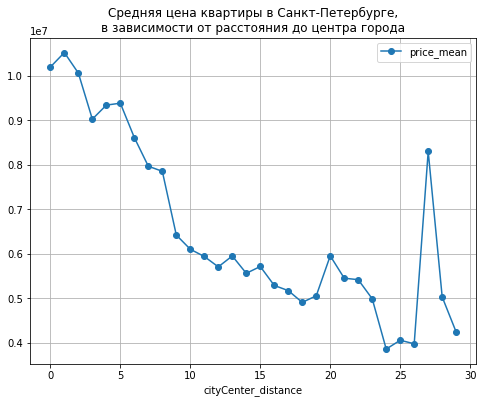

In [144]:
distance_price_spb['price_mean'].plot(legend=True, figsize=(8, 6), style='o-', grid=True)
plt.title('Средняя цена квартиры в Санкт-Петербурге,\nв зависимости от расстояния до центра города')
plt.show()

In [145]:
print('До 10 км от центра города: Падение средней цены на каждый км удаления от центра:', 
      round((distance_price_spb['price_mean'][10] - distance_price_spb['price_mean'][0]) / 10), 'руб/км')
print('10-29 км от центра города: Падение средней цены на каждый км удаления от центра:', 
      round((distance_price_spb['price_mean'][29] - distance_price_spb['price_mean'][10]) / 19), 'руб/км')

До 10 км от центра города: Падение средней цены на каждый км удаления от центра: -409896 руб/км
10-29 км от центра города: Падение средней цены на каждый км удаления от центра: -98050 руб/км


ВЫВОДЫ:

На графике видим, что на первых 10 км от центра города средняя цена на квартиры падает быстрее всего - почти на 410 тыс. рублей на каждый километр удаления. Дальше темп снижается до примерно 100 тыс. рублей на каждый километр. Ближе к границе города на расстоянии от 20-25 км от центра на графике появляются "шумы" и всплески значений средней цены. Как уже говорилось, это связано с малым количеством квартир.

К примеру, на расстоянии 27 км от центра наблюдается самый большой пик на графике (8.3 млн. руб.), так как в датасете всего две квартиры на таком расстоянии. На предыдущем графике этот пик не так заметен, значение средней цены не превышает 5.3 млн. руб., так как влияние цены этих двух квартир "размыто" большим количеством (99) квартир из пригородов и городов-спутников Санкт-Петербурга.

<br><br><br><br>

# 5. Общий вывод

### 5.1. В результате предобработки данных:

Из датасета были удалены дублированные записи, во всех 22 столбцах исследованы и заполнены пропущенные значения, где это было возможно, преобразованы типы данных при необходимости, исправлены, или удалены экстремальные значения, исправлены неявные дубликаты.

Для удобства последующего анализа были рассчитаны и добавлены новые столбцы:
- square_meter_price - цена за квадратный метр
- week_day - день недели публикации
- month - месяц публикации
- year - год публикации
- floor_type - тип этажа квартиры
- cityCenter_distance - расстояние до центра города в км

### 5.2. В результате проведённого исследовательского анализа данных:

Изучены и описаны такие параметры квартир, как:
- Площадь (общая, жилая, кухня);
- Цена квартиры;
- Количество комнат;
- Высота потолков;
- Этаж квартиры;
- Тип этажа;
- Этажность дома;
- Расстояние (до центра города, до аэропорта до ближайшего парка);
- День и Месяц публикации объявления.

Изучено, как быстро продавались квартиры:
- Установлено, что срок продажи квартиры характерен в границах от 1 до 550 дней. Свыше 550 дней уже нетипичные значения, выбросы (их порядка 7.5%, что приводит к тому, что среднее значение по столбцу в 1.75 раз превышает медиану).
- Обычно продажа квартиры занимает около 3.5 месяцев.
- Быстрыми можно считать продажи квартиры менее чем за 1.5 месяца, а необычно долгими - более чем за 8 месяцев.

Изучено влияние на стоимость квартиры следующих параметров:
- Общая площадь - выявлена прямая сильная взаимосвязь с ценой квартиры, (к-т корреляции Пирсона r = 0.77)
- Жилая площадь - выявлена прямая заметная взаимосвязь с ценой квартиры, (r = 0.67)
- Площадь кухни - выявлена прямая заметная взаимосвязь с ценой квартиры, (r = 0.59)
- Количество комнат - выявлена прямая взаимосвязь с ценой квартиры
- Тип этажа – выявлена зависимость цены квартиры от типа этажа. Квартира на первом этаже ценится меньше всего (средняя цена меньше на 1.25 млн. руб.) А средняя цена квартиры на последнем этаже меньше на 0.5 млн. руб., чем у квартир на других этажах
- День недели - взаимосвязи с ценой квартиры не выявлено
- Месяц - взаимосвязи с ценой квартиры не выявлено
- Год – не смотря на то, что из года в год средняя цена на квартиры снижалась вплоть до 2019 года (2015 - 6.15 млн. руб, 2016 - 5.46 млн. руб., 2017 - 5.34 млн. руб., 2018 - 5.29 млн. руб., 2019 - 5.74 млн. руб.), это скорее следствие внешних факторов, таких, как экономическая, или политическая ситуация в стране

Также для ТОП-10 населённых пунктов с наибольшим числом объявлений была рассчитана средняя цена квадратного метра.
- Определены населённые пункты с самой высокой стоимостью жилья: Санкт-Петербург (108681 р./м.кв.) и Пушкин (101826 р./м.кв.)
- и с самой низкой стоимостью: Выборг (58343 р./м.кв.) и Всеволожск (67268 р./м.кв.)

Кроме того была исследована зависимость средней цены на квартиру от расстояния до центра города:
- На первых 10 км от центра города средняя цена на квартиры падает быстрее всего – с 10.2 до 6.1 млн. руб. – почти на 410 тыс. рублей на каждый километр удаления.
- Дальше, на дистанции 10-29 км от центра темп снижается – средняя цена падает с 6.1 до ~4 млн. руб., примерно на 100 тыс. рублей на каждый километр.

### 5.3. Итак:

- На цену квартиры сильно влияют такие параметры, как площадь, количество комнат, этаж расположения, населенный пункт и расстояние до центра города.
- Влияние дня недели и месяца размещения объявления на цену квартиры не выявлено.
- Влияние года размещения объявления на цену квартиры зависит скорее от внешних факторов (от экономической ситуации в стране, например) и в рамках данного датасета детально изучить не представляется возможным.